<a href="https://www.kaggle.com/code/azeemkhan03/4personality-prediction-using-nlp-ml?scriptVersionId=126798087" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

Introversion (I) – Extroversion (E)

Intuition (N) – Sensing (S)

Thinking (T) – Feeling (F)

Judging (J) – Perceiving (P)

# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
#from pywaffle import Waffle
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer

try:
    nltk.data.find('wordnet.zip')
except:
    import subprocess
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    
from nltk.corpus import wordnet

try: 
    nltk.data.find('stopwords.zip')
except:
    import subprocess
    nltk.download('stopwords', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/stopwords.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    
from nltk.corpus import stopwords

import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import HistGradientBoostingClassifier

import plotly.express as px
import warnings


from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

import squarify
from sklearn.metrics import f1_score

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

replace /kaggle/working/corpora/stopwords/dutch? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [2]:
#from nltk.corpus import wordnet
wordnet.synsets("hello")


[Synset('hello.n.01')]

In [3]:
#nltk.data.path.append('/usr/share/nltk_data/corpora/stopwords')

In [4]:
#nltk.data.find('stopwords')

In [5]:
#nltk.download('wordnet', '/root')

In [6]:
def sampling(mode, df, col_name, class_names, count):
    """
    Samples the dataframe based on the mode, given class names and count.

    Parameters:
    -----------
    mode: str
        Either 'under' or 'over'
    df : pandas.DataFrame
        Input DataFrame to be undersampled
    col_name : str
        Name of the column containing the target class
    class_names : list
        List of target class names to be undersampled
    count : int
        Number of samples to be kept for each class

    Returns:
    --------
    pandas.DataFrame
        Undersampled DataFrame or Oversampled
    """
    dfs = []
    for class_name in class_names:
        if mode == 'under':
            df_class = df[df[col_name] == class_name]
            if len(df_class) > count:
                df_class = df_class.sample(count, replace=False)
            dfs.append(df_class)
        elif mode == 'over':
            df_class = df[df[col_name] == class_name]
            if len(df_class) < count:
                df_class = df_class.sample(count, replace=True)
            dfs.append(df_class)
    dfs = pd.concat(dfs)
    df_x = df[~df[col_name].isin(class_names)]
    return pd.concat([dfs,df_x])


# After the completion of the project, we've created functions for different functionalities and displayed them here as a way to abstract the complexity of the code and promote readability.

# Function for splitting the data in train and test

In [7]:
def get_train(train_data):
    
    X_train = np.vstack(np.array(train_data.posts))
    y_train = np.array(train_data.type)
    
    return X_train, y_train

In [8]:
def split(df, size):
    
    # Cleaning The Data
    df.posts, length = clear_text(df)
    
    #Splitting into train & test
    print("Splitting into train & test")
    train_data,test_data=train_test_split(df,test_size=size,random_state=0,stratify=df.type)
    
    #Applying Tfidf Vectorization
    print("Applying Tfidf Vectorization")
    vectorizer=TfidfVectorizer(max_features=5000,stop_words='english',tokenizer=Lemmatizer())
    vectorizer.fit(train_data.posts)
    
    #Applying the vectorizer transform
    train_post=vectorizer.transform(train_data.posts).toarray()
    test_post=vectorizer.transform(test_data.posts).toarray()
    
    #Label Encoding the classes as 0,1,2,3......
    print("Label Encoding the classes")
    target_encoder= LabelEncoder()
    
    #Getting the final train and test
    print("Getting the final train and test")
    train_target=target_encoder.fit_transform(train_data.type)
    test_target=target_encoder.fit_transform(test_data.type)
    print(target_encoder.classes_)
    return train_post, test_post, train_target, test_target  

# Function for Data Cleaning

In [9]:
def clear_text(df):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    stop_words = set(stopwords.words('english')) # Load stop words
    pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
    pers_types = [p.lower() for p in pers_types]
    
    print("Cleaning The Dataset")
    for sentence in tqdm(df.posts):
        
        sentence=sentence.lower()
        
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
        
        sentence=re.sub('[^0-9a-z]',' ',sentence)
        
        sentence = " ".join([word for word in sentence.split() if word not in stop_words]) # Remove stop words
        #print(len(sentence))
        
        for p in pers_types:
            sentence = re.sub(p, '', sentence)
        #print(len(sentence))
        
        sentence = lemmatizer.lemmatize(sentence) # Lemmatize words
        
        data_length.append(len(sentence.split())) #Split data, measure length of new filtered data
        
        cleaned_text.append(sentence)
        
    return cleaned_text,data_length


# As wordnetlemmatizer() itself is not callable

In [10]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

# Function for Running all the models


In [11]:
def model(X_train, X_test, y_train, y_test, count):
    models_accuracy={}
    report = {}
    f1_scores={}
    
    #KNN
    print("Running KNN")
    neigh=KNeighborsClassifier()
    neigh.fit(X_train,y_train)
    
    #showing accuracy and f1_scores
    models_accuracy['KNN']=accuracy_score(y_test,neigh.predict(X_test))
    f1_scores['KNN']=f1_score(y_test,neigh.predict(X_test),average='macro')
    
    report['KNN'] = classification_report(y_train,neigh.predict(X_train),zero_division=0)
    

    
    #Logistic Regression
    print("Running Logistic Regression")
    
    model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
    model_log.fit(X_train,y_train)
    
    models_accuracy['Logistic Regression']=accuracy_score(y_test,model_log.predict(X_test))
    f1_scores['Logistic Regression']=f1_score(y_test,model_log.predict(X_test),average='macro')
    
    
    report['Logistic Regression'] = classification_report(y_train,model_log.predict(X_train),zero_division=0)
    
    
    #Linear SVC
    print("Running Linear SVC")
    model_linear_SVC=LinearSVC(C=0.1)
    model_linear_SVC.fit(X_train,y_train)
    
    models_accuracy['Linear Support Vector Classifier']=accuracy_score(y_test,model_linear_SVC.predict(X_test))
    f1_scores['Linear Support Vector Classifier']=f1_score(y_test,model_linear_SVC.predict(X_test),average='macro')
    
    report['Linear Support Vector Classifier'] = classification_report(y_test,model_linear_SVC.predict(X_test),target_names=target_encoder.inverse_transform([i for i in range(count)]),zero_division=0)
    
    '''
    #SVC
    
    print("Running SVC")
    model_svc=SVC()
    model_svc.fit(X_train,y_train)
    
    models_accuracy['Support Vector classifier']=accuracy_score(y_test,model_svc.predict(X_test))
    f1_scores['Support Vector Classifier']=f1_score(y_test,model_svc.predict(X_test),average='macro')
    
    report['Support Vector classifier'] = classification_report(y_test,model_svc.predict(X_test),target_names=target_encoder.inverse_transform([i for i in range(count)]),zero_division=0)
    '''
    
    #Multinomial Naive Bayes
    print("Running Multinomial Naive Bayes")
    model_multinomial_nb=MultinomialNB()
    model_multinomial_nb.fit(X_train,y_train)    
    
    
    models_accuracy['Multinomial Naive Bayes']=accuracy_score(y_test,model_multinomial_nb.predict(X_test))
    f1_scores['Multinomial Naive Bayes']=f1_score(y_test,model_multinomial_nb.predict(X_test),average='macro')
    
    report['Multinomial Naive Bayes'] = classification_report(y_test,model_multinomial_nb.predict(X_test),target_names=target_encoder.inverse_transform([i for i in range(count)]),zero_division=0)
    
    #Decision Tree Classifier
    print("Running Decision Tree Classifier")
    model_tree=DecisionTreeClassifier(max_depth=14)
    model_tree.fit(X_train,y_train)
    
    models_accuracy['Decision Tree classifier']=accuracy_score(y_test,model_tree.predict(X_test))
    f1_scores['Decision Tree classifier']=f1_score(y_test,model_tree.predict(X_test),average='macro')
    
    
    report['Decision Tree classifier'] = classification_report(y_test,model_tree.predict(X_test),target_names=target_encoder.inverse_transform([i for i in range(count)]))
    
    
    #Random Forest
    print("Running Random Forest")
    model_forest=RandomForestClassifier(max_depth=10)
    model_forest.fit(X_train,y_train)
    
    models_accuracy['Random Forest Classifier']=accuracy_score(y_test,model_forest.predict(X_test))
    f1_scores['Random Forest Classifier']=f1_score(y_test,model_forest.predict(X_test),average='macro')
    
    report['Random Forest Classifier'] = classification_report(y_test,model_forest.predict(X_test),target_names=target_encoder.inverse_transform([i for i in range(count)]),zero_division=0)
    
    
    
    accuracy_under=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])
    f1_under=pd.DataFrame(f1_scores.items(),columns=['Models','Test F1 Score'])
    
    return accuracy_under, report, f1_under
    

# Creating a dataframe

In [12]:
df=pd.read_csv('/kaggle/input/mbti-type/mbti_1.csv', index_col=False)

# Getting general ideas of the data

_Our data only has two columns, "Personality Type and posts"_

_"In posts, different things written online by each personality type is given"_

_"They are separated with a || marker"_

In [13]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [14]:
df.shape

(8675, 2)

In [15]:
df.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


# Checking Null values count and dtype

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


# Count of Data for Each Personality Type

In [17]:
df['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

Text(0.5, 1.0, 'Total post each personality type')

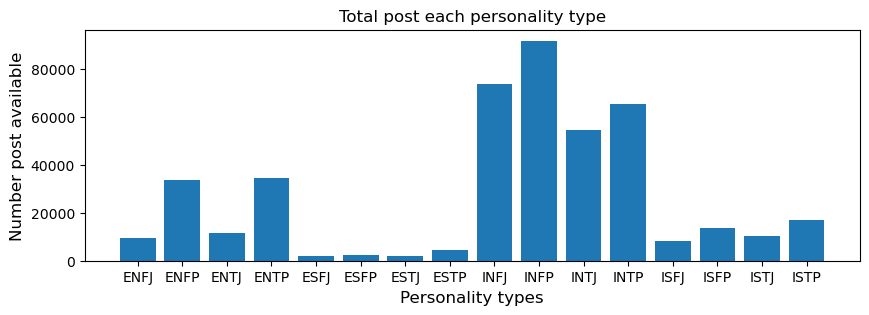

In [18]:
total = df.groupby(['type']).count()*50
plt.figure(figsize = (10,3))
plt.bar(np.array(total.index), height =total['posts'],)
plt.xlabel('Personality types', size = 12)
plt.ylabel('Number post available', size = 12)
plt.title('Total post each personality type')

### _Inference : We see that the data is inbalanced and we'll have to do some sort of treatment so that the model doesn't have biasness towards a specific data_

# What "posts" actually is ?

In [19]:
df.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [20]:
len(df.posts[0])

4652

# Finding the most common words in all posts.

In [21]:
from collections import Counter
words = list(df["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(50)

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263),
 ('my', 104561),
 ('it', 93101),
 ('for', 83057),
 ('have', 79784),
 ('with', 77131),
 ('but', 74729),
 ('be', 69317),
 ('are', 65034),
 ('like', 61390),
 ('not', 59496),
 ('an', 59020),
 ("I'm", 57339),
 ('on', 57062),
 ('was', 56146),
 ('me', 55488),
 ('as', 53310),
 ('this', 52601),
 ('just', 48292),
 ('about', 46305),
 ('think', 46229),
 ('or', 45724),
 ("don't", 44821),
 ('so', 42935),
 ('your', 40918),
 ('do', 40867),
 ('what', 37746),
 ('at', 37566),
 ('can', 37535),
 ('if', 37042),
 ('people', 35546),
 ('when', 34389),
 ('would', 32605),
 ('really', 31369),
 ('all', 31344),
 ('more', 31188),
 ('know', 31130),
 ('they', 29386),
 ('get', 28948),
 ('because', 27438),
 ('am', 27109)]

The posts contain general words like : I, to, the, a, and, of, is, you etc.

we assume that these words don't really provide any useful information to train the Machine Learning model as most of them are stop-words or other useless words.

# Data Visualization

In [22]:
plt.figure(figsize=(20,20))
px.pie(df,names='type',title='Personality type',hole=0.2)

<Figure size 2000x2000 with 0 Axes>

## Tree Plot

In [23]:
count=dict(df['type'].value_counts())

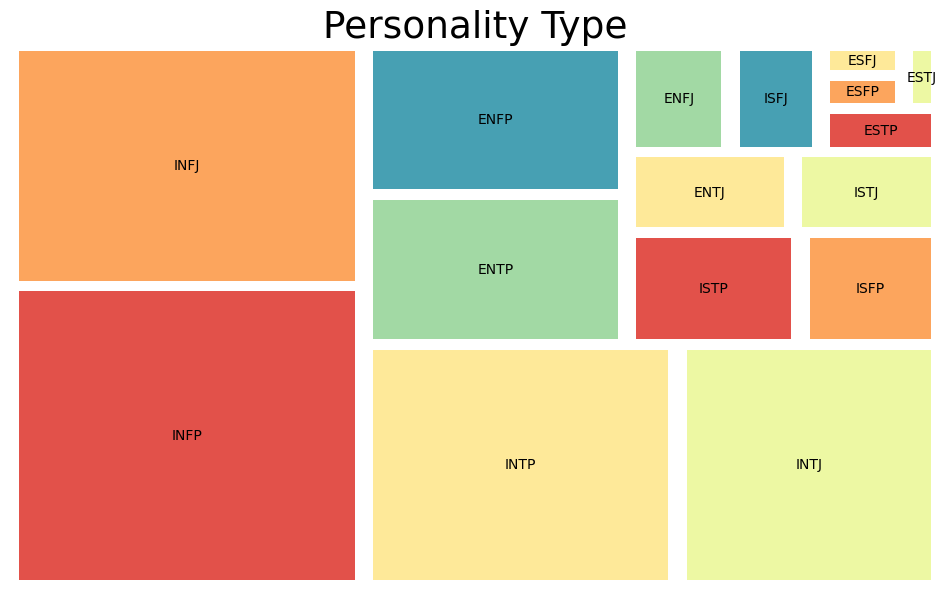

In [24]:
plt.figure(figsize=(12,7))
squarify.plot(sizes=count.values(),color=sns.color_palette("Spectral"),pad=2,label=count.keys())
plt.title('Personality Type', fontsize=27)
plt.axis('off')
plt.show()

# Stem Plot

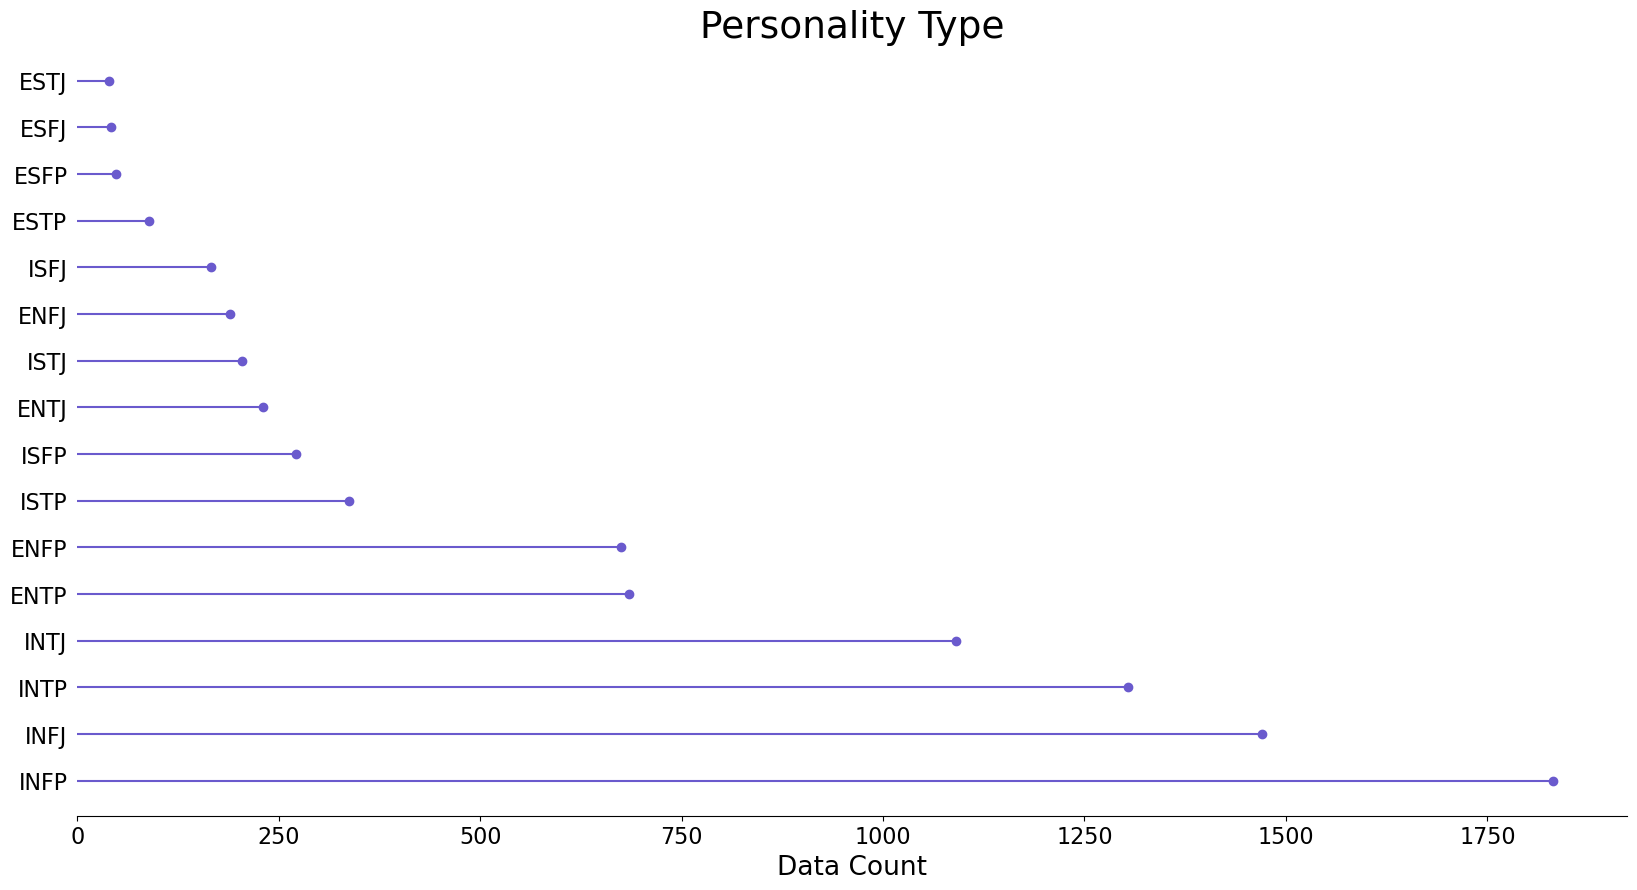

In [25]:
plt.figure(figsize=(20,10))
plt.hlines(y=count.keys(), xmin=0, xmax=count.values(), color='slateblue')
plt.plot(count.values(),count.keys(), 'o', color='slateblue')
plt.title('Personality Type', fontsize=27)
plt.xlabel('Data Count', fontsize=19)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, None)
plt.tick_params(left=False)
sns.despine(left=True)
plt.show()

In [26]:
df = df.copy()
#this function counts the no of words in each post of a user
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))


## The 2 histogram plots represent Gaussian distribution of a sample space, which in our case comprises of no. of words per comment and associated variance of word counts from our dataset.

<Figure size 1500x1000 with 0 Axes>

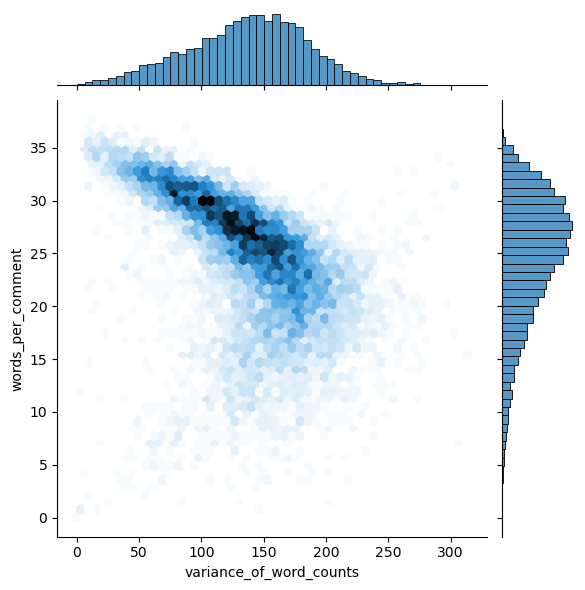

In [27]:
plt.figure(figsize=(15,10))
sns.jointplot(x=df["variance_of_word_counts"],y=df["words_per_comment"],kind="hex")




_In the hexagonal plot, the hexagon with most number of points gets darker color._ 

_So  most of the posts have words between 100 and 150 and most of no. of words per comment by a user is between 25-30._

_We can see that there is no correlation observed between variance of word count and the words per comment._

_There is a strong relationship when there are 25-30 words per comment & the variance of word counts is 100-150_


# Distance Plot

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 1.0, 'Distribution of Lengths of all 50 Posts')

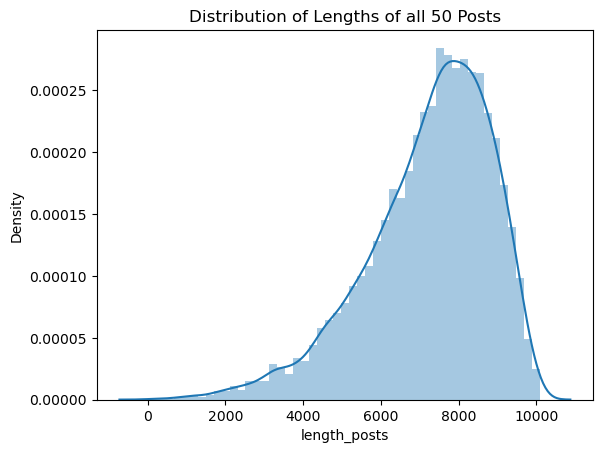

In [28]:
df["length_posts"] = df["posts"].apply(len)
sns.distplot(df["length_posts"]).set_title("Distribution of Lengths of all 50 Posts")

We can see that most no of lengthly posts have between 7000-9000 words.

The line represents the kernel density estimation. 

It is a fundamental data smoothing problem where inferences about the population, based on a finite data sample. 

This kernel density estimate is a function defined as the sum of a kernel function on every data point.

## Wordcloud For Each Independent Class

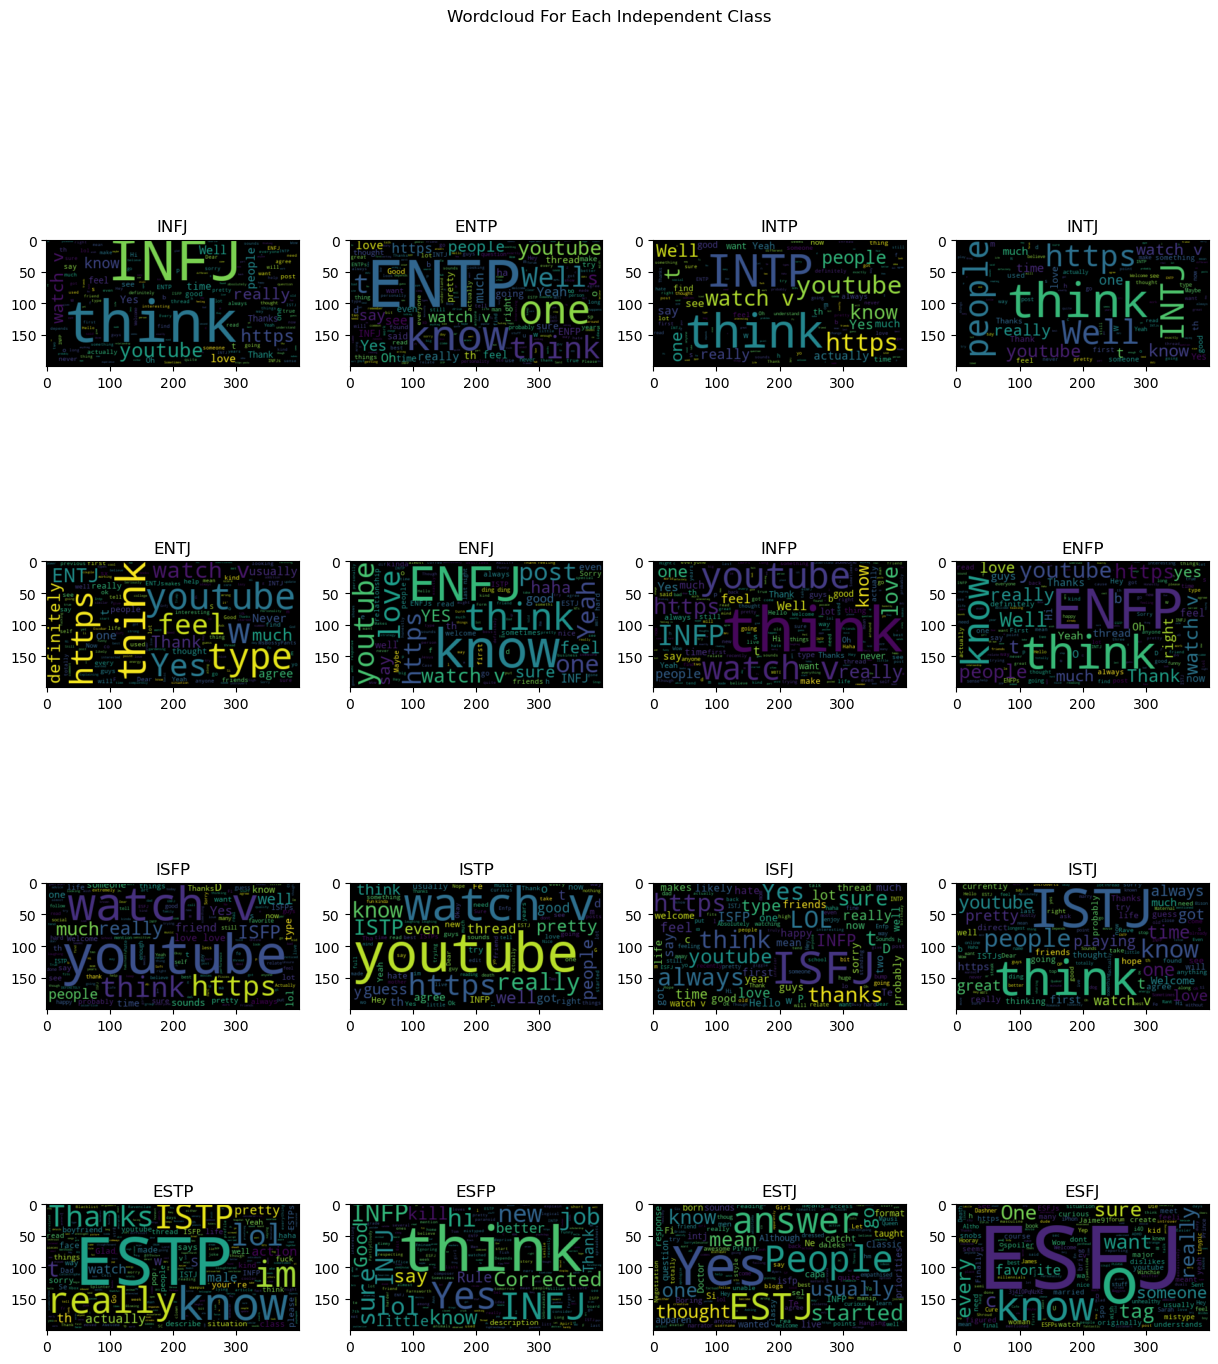

In [29]:
fig, ax = plt.subplots(len(df['type'].unique()), figsize=(15,len(df['type'].unique())))
plt.suptitle("Wordcloud For Each Independent Class")
k = 0
for i in df['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    
    ax[k].axis("off")
    k+=1

## _We can see there are a number of irrelevant words present in the dataset (e.g. ha, ar, Ti etx.) which will need to be removed_

# Data Cleaning

In [30]:
#nltk.download('all')

In [31]:
#import nltk

In [32]:
#ltk.data.find('wordnet.zip')

In [33]:
#nltk.data.path.append("/kaggle/working/nltk_data/")

In [34]:
from nltk.corpus import wordnet
wordnet.synsets("hello")


[Synset('hello.n.01')]

In [35]:
#nltk.data.path

In [36]:
#from nltk.stem import *

In [37]:
#from nltk.corpus import *

In [38]:
df_clean = df
df_clean.posts,df_clean_length=clear_text(df)
df_clean

Cleaning The Dataset


100%|██████████| 8675/8675 [00:09<00:00, 958.02it/s] 


,type,posts,words_per_comment,variance_of_word_counts,length_posts
0,INFJ,moments sportscenter top ten plays pranks lif...,11.12,135.2900,4652
1,ENTP,finding lack posts alarming sex boring positio...,23.40,187.4756,7053
2,INTP,good one course say know blessing curse absolu...,16.72,180.6900,5265
3,INTJ,dear enjoyed conversation day esoteric gabbin...,21.28,181.8324,6271
4,ENTJ,fired another silly misconception approaching ...,19.34,196.4576,6111
...,...,...,...,...,...
8670,ISFP,always think cats fi doms reason websites beco...,15.92,125.3300,5011
8671,ENFP,thread already exists someplace else heck dele...,26.18,125.6144,7902
8672,INTP,many questions things would take purple pill p...,18.96,169.7764,5772
8673,INFP,conflicted right comes wanting children honest...,34.10,57.0336,9479


In [39]:
df_clean.posts[0]

' moments sportscenter top ten plays pranks life changing experience life repeat today may perc experience immerse last thing  friend posted facebook committing suicide next day rest peace 7 sorry hear distress natural relationship perfection time every moment existence try figure hard times times growth 84389 84390 welcome stuff game set match prozac wellbrutin least thirty minutes moving legs mean moving sitting desk chair weed moderation maybe try edibles healthier alternative basically come three items determined type whichever types want would likely use given types cognitive functions whatnot left things moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear  favorite video games growing current favorite video games cool appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always around yo  ladies compliment

In [40]:
len(df_clean.posts[0])

2035

## WordCloud For Each Independent Class After Performing Data Cleaning

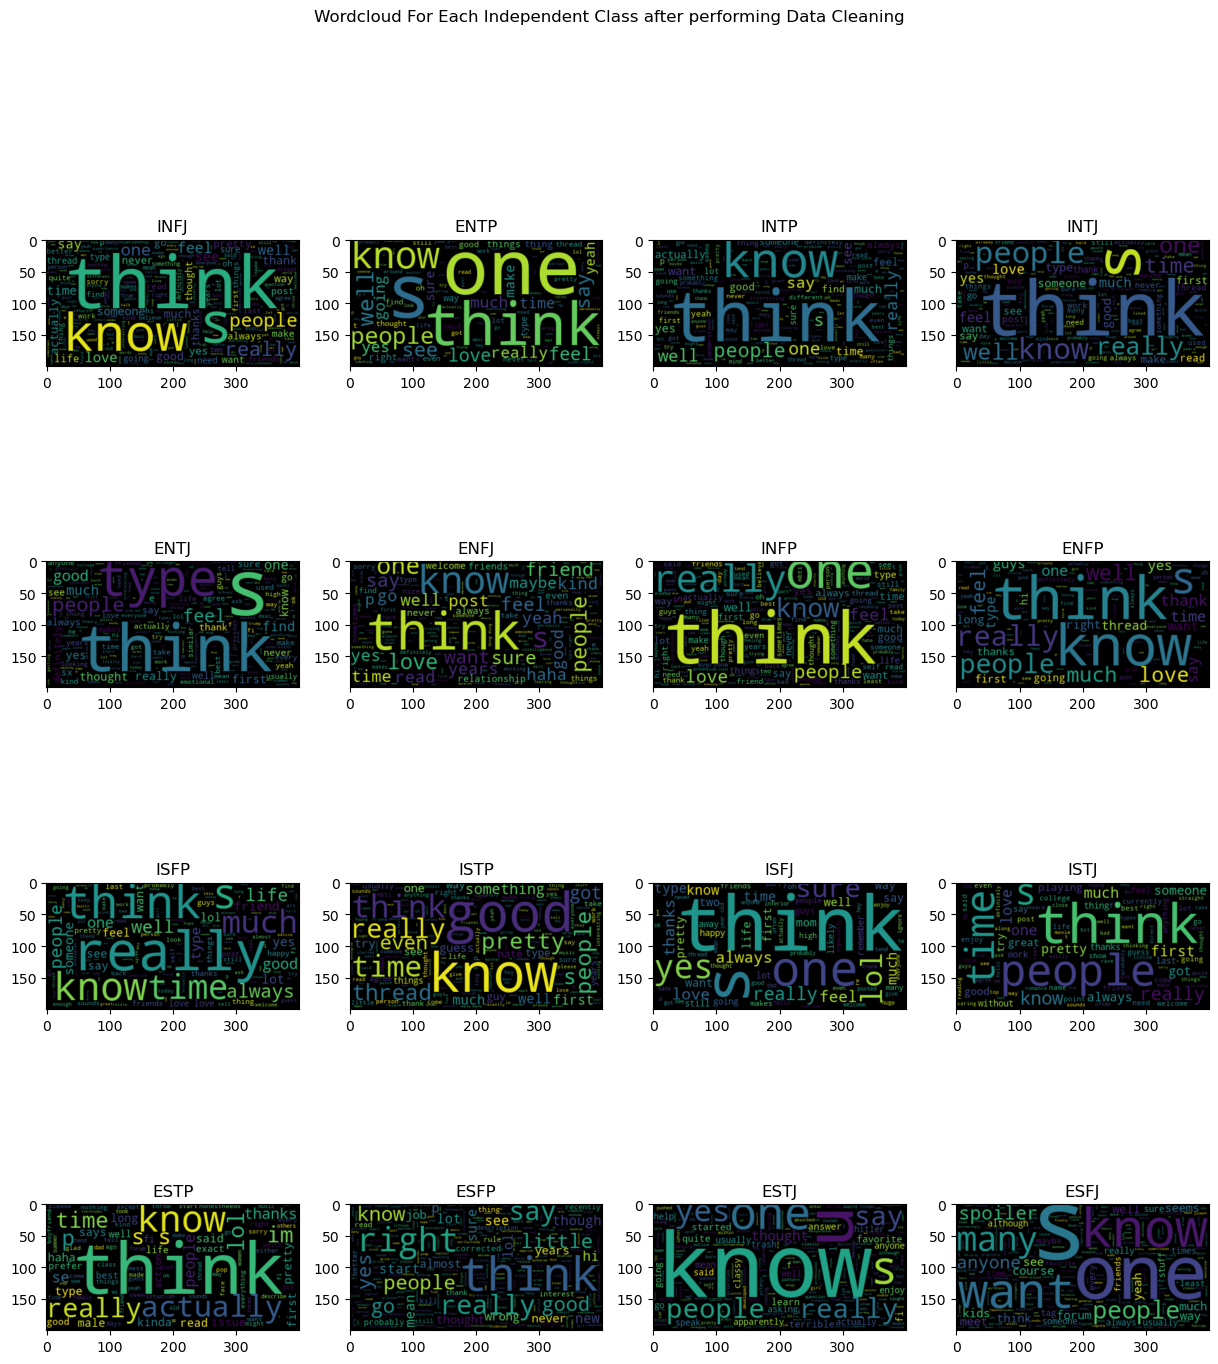

In [41]:
fig, ax = plt.subplots(len(df_clean['type'].unique()), figsize=(15,len(df_clean['type'].unique())))
plt.suptitle("Wordcloud For Each Independent Class after performing Data Cleaning")
k = 0
for i in df_clean['type'].unique():
    df_4 = df_clean[df_clean['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

In [42]:
from collections import Counter
words = list(df_clean["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(50)

[('like', 69675),
 ('think', 49837),
 ('people', 47855),
 ('one', 37167),
 ('know', 36937),
 ('really', 35291),
 ('would', 35015),
 ('get', 30804),
 ('time', 27610),
 ('feel', 23337),
 ('much', 23120),
 ('well', 22926),
 ('s', 22118),
 ('love', 21094),
 ('good', 20720),
 ('things', 20487),
 ('say', 20267),
 ('way', 19653),
 ('something', 19538),
 ('want', 19378),
 ('see', 19136),
 ('also', 18330),
 ('type', 17149),
 ('even', 16914),
 ('always', 16809),
 ('lot', 16440),
 ('someone', 16135),
 ('make', 15869),
 ('life', 15394),
 ('could', 15288),
 ('never', 15250),
 ('go', 15116),
 ('though', 14682),
 ('thing', 14154),
 ('find', 14147),
 ('actually', 13213),
 ('person', 12808),
 ('right', 12711),
 ('going', 12710),
 ('first', 12649),
 ('sure', 12631),
 ('pretty', 12341),
 ('yes', 12277),
 ('friends', 12164),
 ('need', 11565),
 ('still', 10998),
 ('work', 10955),
 ('thought', 10633),
 ('said', 10558),
 ('many', 10383)]

# Demonstration of How label encoder works in our code

In [43]:
target_encoder=LabelEncoder()
target_encoder.fit(df.type)

LabelEncoder()

In [44]:
le_name_mapping = dict(zip(target_encoder.classes_, target_encoder.fit_transform(target_encoder.classes_)))
new_dict = dict([(value, key) for key, value in le_name_mapping.items()])
new_dict

{0: 'ENFJ',
 1: 'ENFP',
 2: 'ENTJ',
 3: 'ENTP',
 4: 'ESFJ',
 5: 'ESFP',
 6: 'ESTJ',
 7: 'ESTP',
 8: 'INFJ',
 9: 'INFP',
 10: 'INTJ',
 11: 'INTP',
 12: 'ISFJ',
 13: 'ISFP',
 14: 'ISTJ',
 15: 'ISTP'}

In [45]:
# saving the models
'''import pickle

with open('dic_name.pkl', 'wb') as file:
    pickle.dump(new_dict, file)'''

"import pickle\n\nwith open('dic_name.pkl', 'wb') as file:\n    pickle.dump(new_dict, file)"

# Model Selection

In [46]:
target_names_orig = 16

## For 80/20 Split

In [47]:
X_train2, X_test2, y_train2, y_test2 = split(df_clean, 0.2)

Cleaning The Dataset


100%|██████████| 8675/8675 [00:04<00:00, 1890.27it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.



Splitting into train & test
Applying Tfidf Vectorization
Label Encoding the classes
Getting the final train and test
['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


In [48]:
X_train2

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.0586486,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [49]:
X_test2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04214726, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06612044, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [50]:
y_train2

array([15,  8,  9, ...,  1,  9,  8])

In [51]:
y_test2

array([11,  3, 11, ...,  1,  9,  8])

In [52]:
model_accuracy_orig2, report_orig2, f1_orig2 = model(X_train2, X_test2, y_train2, y_test2, target_names_orig)
model_accuracy_orig2.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


,Models,Test accuracy
0,Linear Support Vector Classifier,0.385591
1,Logistic Regression,0.366571
2,Multinomial Naive Bayes,0.306052
3,Random Forest Classifier,0.251873
4,Decision Tree classifier,0.223055
5,KNN,0.212104


In [53]:
f1_orig2.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Linear Support Vector Classifier,0.148025
1,Logistic Regression,0.115058
2,Decision Tree classifier,0.087935
3,KNN,0.082536
4,Multinomial Naive Bayes,0.080212
5,Random Forest Classifier,0.048416


## For 70/30 Split

In [54]:
X_train3, X_test3, y_train3, y_test3 = split(df_clean, 0.3)

Cleaning The Dataset


100%|██████████| 8675/8675 [00:04<00:00, 1940.60it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.



Splitting into train & test
Applying Tfidf Vectorization
Label Encoding the classes
Getting the final train and test
['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


In [55]:
model_accuracy_orig3, report_orig3, f1_orig3 = model(X_train3, X_test3, y_train3, y_test3, target_names_orig)

model_accuracy_orig3.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')


Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


,Models,Test accuracy
0,Linear Support Vector Classifier,0.374568
1,Logistic Regression,0.357280
2,Multinomial Naive Bayes,0.293123
3,Random Forest Classifier,0.252017
4,KNN,0.216673
5,Decision Tree classifier,0.210526


In [56]:
f1_orig3.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Linear Support Vector Classifier,0.148617
1,Logistic Regression,0.111524
2,Decision Tree classifier,0.086967
3,KNN,0.076367
4,Multinomial Naive Bayes,0.073563
5,Random Forest Classifier,0.051050


## Performance Visualisation

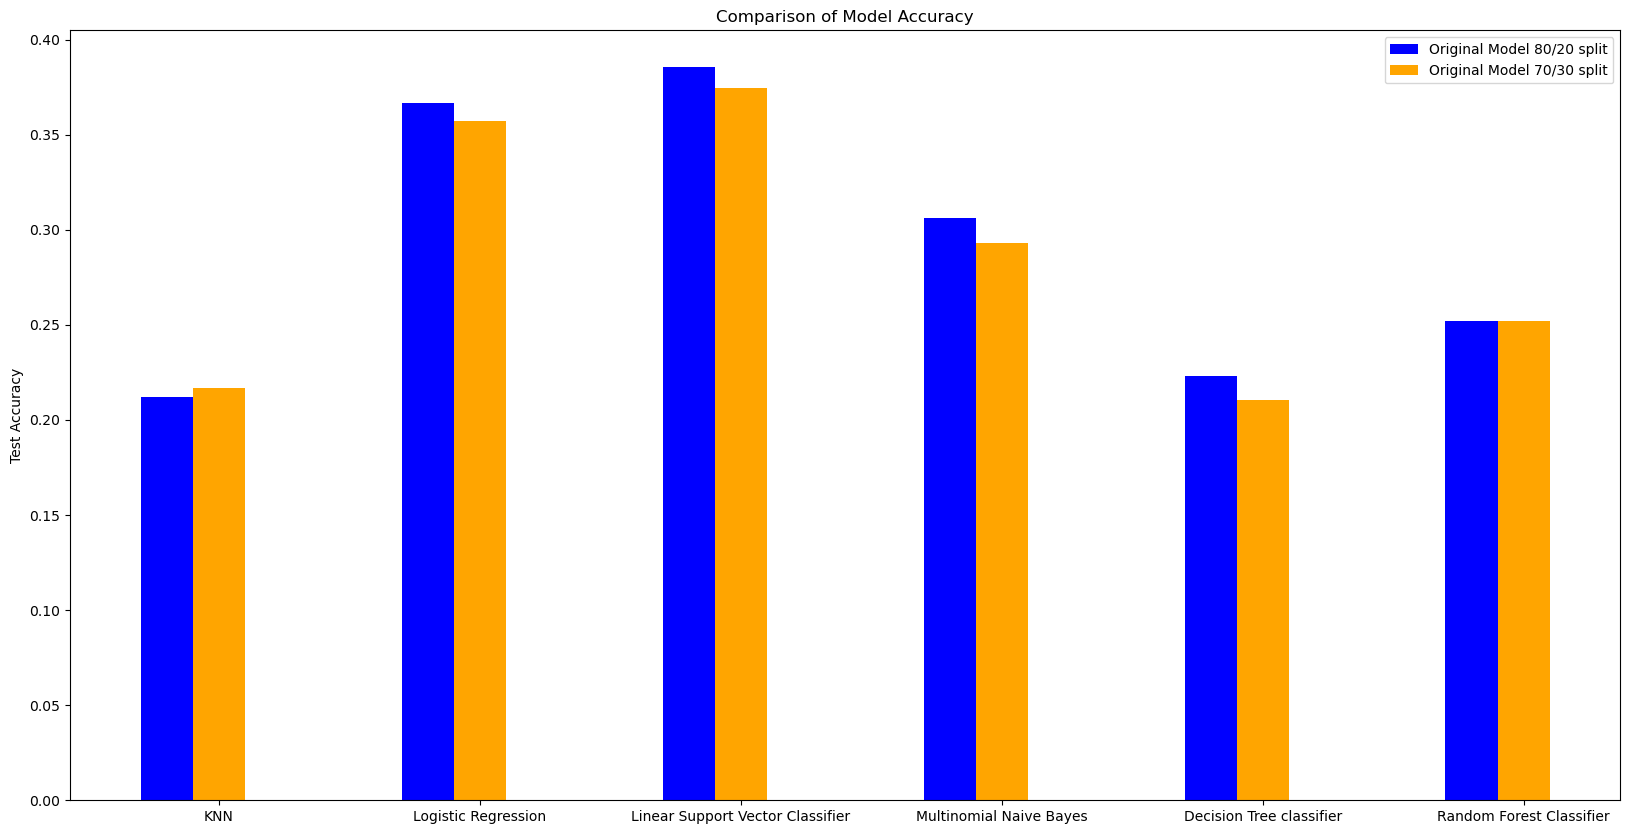

In [57]:
fig, ax = plt.subplots(figsize=(20, 10))
# Set width of each bar
bar_width = 0.2

# Set position of bars on X axis
r1 = np.arange(len(model_accuracy_orig2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, model_accuracy_orig2['Test accuracy'], color='blue', width=bar_width, label='Original Model 80/20 split')
plt.bar(r2, model_accuracy_orig3['Test accuracy'], color='orange', width=bar_width, label='Original Model 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(model_accuracy_orig2['Models']))], model_accuracy_orig2['Models'])

# Add y axis label and title
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Accuracy')

# Add legend
plt.legend()

# Show plot
plt.show()


## Since Models are performing poorly, we will try to incorporate few preprocessing techniques

In [58]:
train_data2 = pd.DataFrame({'posts': list(X_train2), 'type': list(y_train2)}, index=None)
train_data2

,posts,type
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
...,...,...
6935,"[0.0, 0.03978110605893184, 0.0, 0.0, 0.0, 0.0,...",11
6936,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10
6937,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
6938,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9


In [59]:
train_data3 = pd.DataFrame({'posts': list(X_train3), 'type': list(y_train3)}, index=None)
train_data3

,posts,type
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
4,"[0.05392913172173782, 0.0, 0.0, 0.0, 0.0, 0.0,...",10
...,...,...
6067,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
6068,"[0.0, 0.0, 0.0, 0.05118042305110309, 0.0, 0.0,...",11
6069,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
6070,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10


## We will keep  'X_test2' & 'y_test2' for testing 3 techniques, since it is very important to keep the test data pure

# Handling Imbalanced Data

{0: 'ENFJ',
 1: 'ENFP',
 2: 'ENTJ',
 3: 'ENTP',
 4: 'ESFJ',
 5: 'ESFP',
 6: 'ESTJ',
 7: 'ESTP',
 8: 'INFJ',
 9: 'INFP',
 10: 'INTJ',
 11: 'INTP',
 12: 'ISFJ',
 13: 'ISFP',
 14: 'ISTJ',
 15: 'ISTP'}

In [60]:
print("For 80/20 split:")
train_data2.type.value_counts()

For 80/20 split:


9     1466
8     1176
11    1043
10     873
3      548
1      540
15     270
13     217
2      185
14     164
0      152
12     133
7       71
5       38
4       33
6       31
Name: type, dtype: int64

In [61]:
print("For 70/30 Split: ")
train_data3.type.value_counts()

For 70/30 Split: 


9     1282
8     1029
11     913
10     764
3      479
1      472
15     236
13     190
2      162
14     144
0      133
12     116
7       62
5       34
4       29
6       27
Name: type, dtype: int64

# 1. Undersampling

## For 80/20 split

### We will only take 600 samples of each type 

In [62]:
train_data_under2= sampling('under', train_data2, 'type', [9,8,11,10,], 600)
train_data_under2

,posts,type
4304,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
1521,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
4720,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
1211,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
584,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
...,...,...
6926,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.057737741953966804...",15
6927,"[0.0, 0.036736062409850403, 0.0, 0.0, 0.0, 0.0...",3
6930,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
6931,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3


In [63]:
np.vstack(np.array(train_data_under2.posts))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
X_test2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04214726, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06612044, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [65]:
train_data_under2.type.value_counts()

9     600
8     600
11    600
10    600
3     548
1     540
15    270
13    217
2     185
14    164
0     152
12    133
7      71
5      38
4      33
6      31
Name: type, dtype: int64

In [66]:
X_train_under2, y_train_under2 = get_train(train_data_under2)

In [67]:
X_train_under2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [68]:
y_train_under2

array([9, 9, 9, ..., 1, 3, 1])

In [69]:
print(X_train_under2.shape, X_test2.shape)

(4782, 5000) (1735, 5000)


In [70]:
print(y_train_under2.shape, y_test2.shape)

(4782,) (1735,)


In [71]:
model_accuracy_under2, report_under2, f1_orig_under2 = model(X_train_under2, X_test2, y_train_under2, y_test2, target_names_orig)

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Running Random Forest


In [72]:
model_accuracy_under2.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test accuracy
0,Linear Support Vector Classifier,0.374640
1,Logistic Regression,0.365994
2,Multinomial Naive Bayes,0.360807
3,Random Forest Classifier,0.290490
4,KNN,0.201153
5,Decision Tree classifier,0.180980


In [73]:
f1_orig_under2.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Linear Support Vector Classifier,0.179607
1,Logistic Regression,0.147990
2,Multinomial Naive Bayes,0.138688
3,Random Forest Classifier,0.117397
4,KNN,0.100079
5,Decision Tree classifier,0.099315


## For 70/30

### We will Take 500 Samples

In [74]:
train_data3.type.value_counts()

9     1282
8     1029
11     913
10     764
3      479
1      472
15     236
13     190
2      162
14     144
0      133
12     116
7       62
5       34
4       29
6       27
Name: type, dtype: int64

In [75]:
train_data_under3 = sampling('under', train_data3, 'type', [9,8,11,10,], 500)
train_data_under3

,posts,type
5106,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
632,"[0.0, 0.0, 0.0, 0.0, 0.06168989680081492, 0.0,...",9
936,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
1605,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
3261,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
...,...,...
6060,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
6062,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14
6063,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
6064,"[0.0, 0.020335363110752184, 0.0, 0.0, 0.277836...",3


In [76]:
train_data_under3.type.value_counts()

9     500
8     500
11    500
10    500
3     479
1     472
15    236
13    190
2     162
14    144
0     133
12    116
7      62
5      34
4      29
6      27
Name: type, dtype: int64

In [77]:
X_train_under3, y_train_under3 = get_train(train_data_under3)

In [78]:
X_train_under3

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02033536, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [79]:
y_train_under3

array([9, 9, 9, ..., 1, 3, 1])

In [80]:
print(X_train_under3.shape, X_test3.shape)

(4084, 5000) (2603, 5000)


In [81]:
print(y_train_under3.shape, y_test3.shape)

(4084,) (2603,)


In [82]:
model_accuracy_under3, report_under3, f1_orig_under3 = model(X_train_under3, X_test3, y_train_under3, y_test3, target_names_orig)

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


In [83]:
model_accuracy_under3.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test accuracy
0,Linear Support Vector Classifier,0.357280
1,Logistic Regression,0.342682
2,Multinomial Naive Bayes,0.338071
3,Random Forest Classifier,0.275836
4,Decision Tree classifier,0.187092
5,KNN,0.172109


In [84]:
f1_orig_under3.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Linear Support Vector Classifier,0.174166
1,Logistic Regression,0.143576
2,Multinomial Naive Bayes,0.135550
3,Random Forest Classifier,0.117309
4,KNN,0.082839
5,Decision Tree classifier,0.080387


# Performance Evaluation For UnderSampling

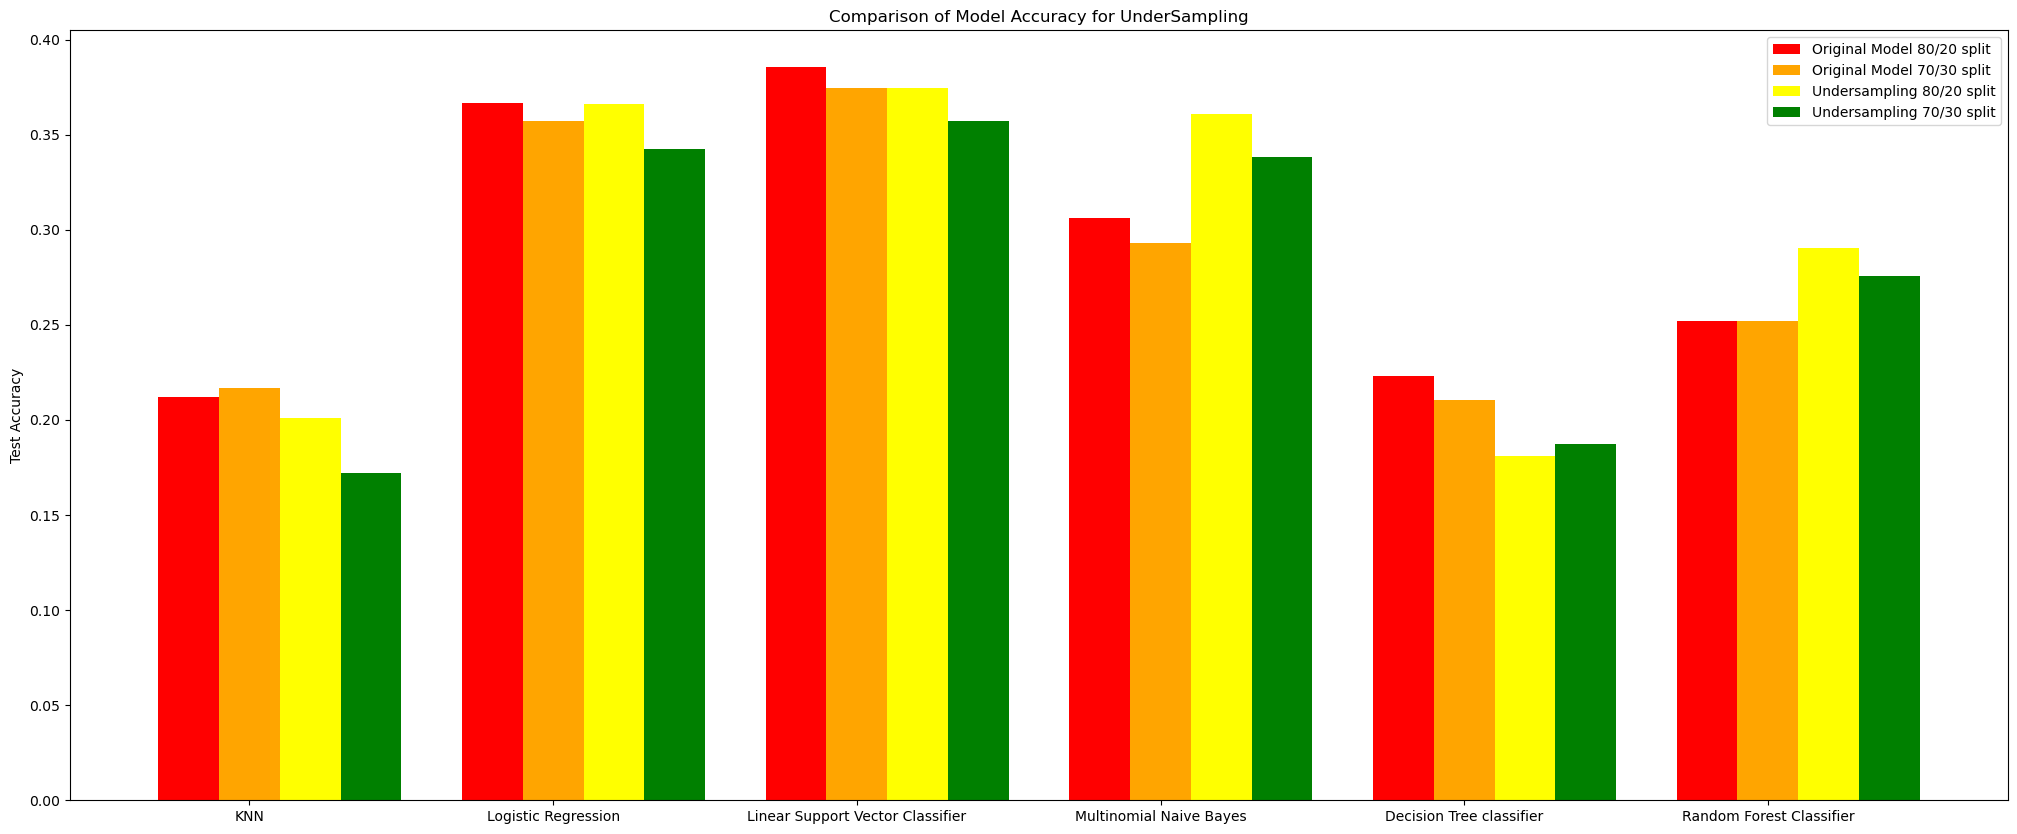

In [85]:
fig, ax = plt.subplots(figsize=(25, 10))
# Set width of each bar
bar_width = 0.2
models = model_accuracy_orig2['Models']
# Set position of bars on X axis
r1 = np.arange(len(model_accuracy_orig2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, model_accuracy_orig2['Test accuracy'], color='red', width=bar_width, label='Original Model 80/20 split')
plt.bar(r2, model_accuracy_orig3['Test accuracy'], color='orange', width=bar_width, label='Original Model 70/30 split')
plt.bar(r3, model_accuracy_under2['Test accuracy'], color='yellow', width=bar_width, label='Undersampling 80/20 split')
plt.bar(r4, model_accuracy_under3['Test accuracy'], color='green', width=bar_width, label='Undersampling 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(models))], models)

# Add y axis label and title
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Accuracy for UnderSampling')

# Add legend
plt.legend()

# Show plot
plt.show()


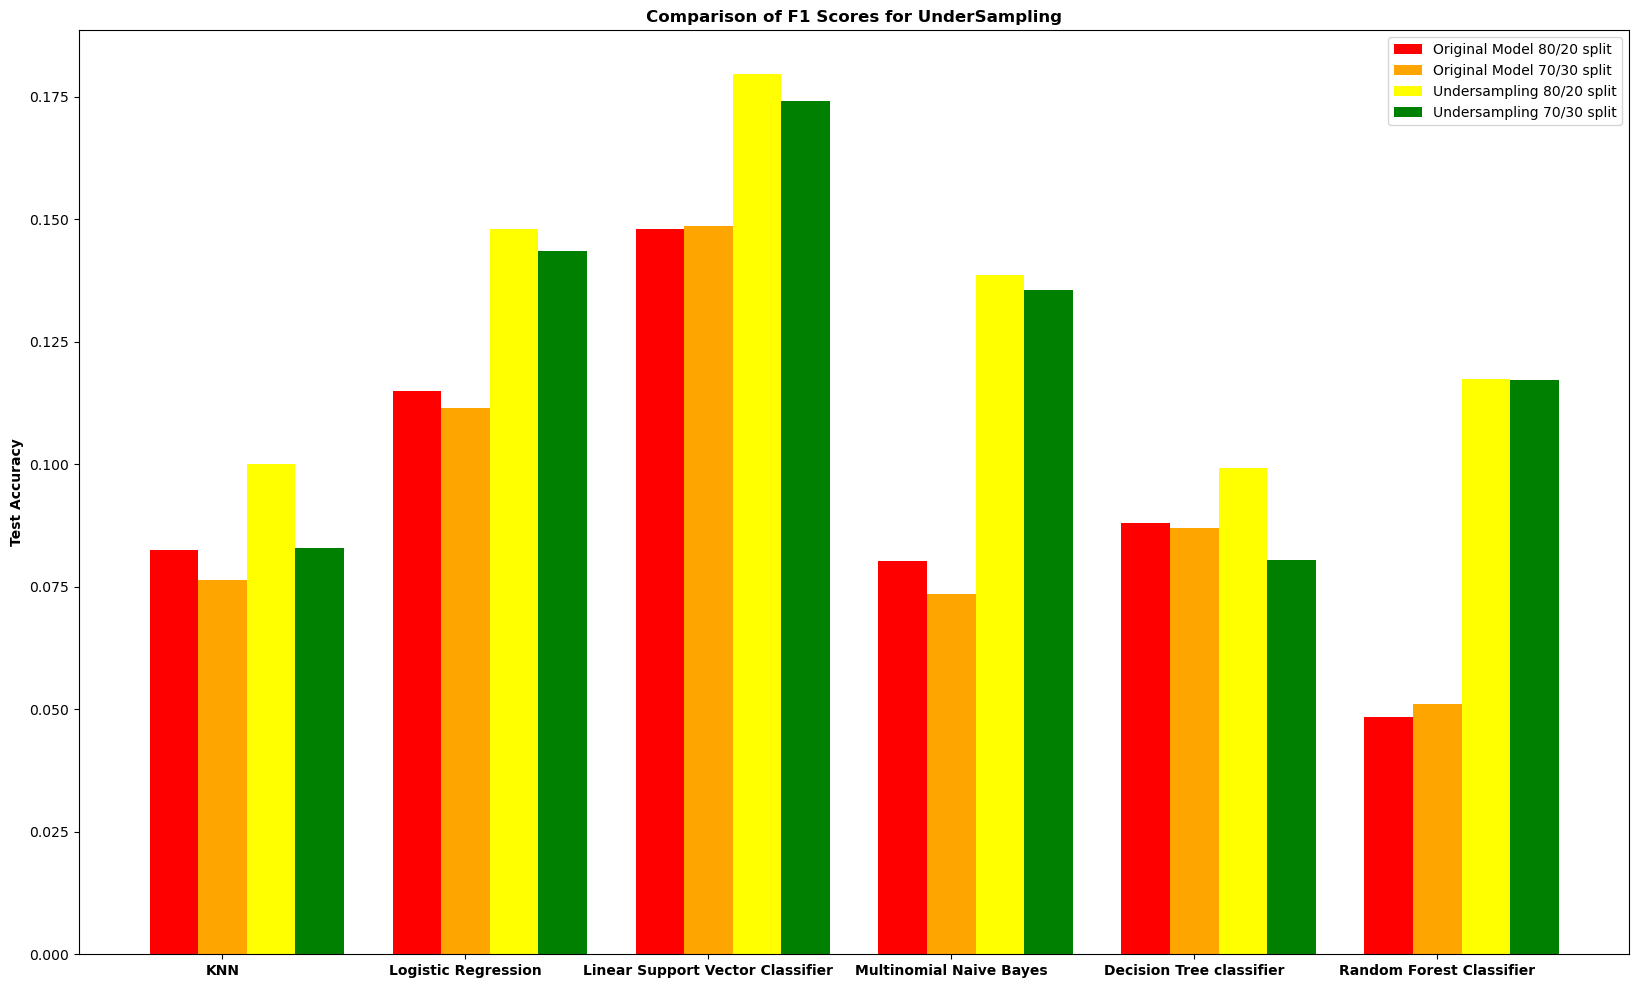

In [86]:
fig, ax = plt.subplots(figsize=(20, 12))
# Set width of each bar
bar_width = 0.2
models = f1_orig2['Models']
# Set position of bars on X axis
r1 = np.arange(len(f1_orig2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, f1_orig2['Test F1 Score'], color='red', width=bar_width, label='Original Model 80/20 split')
plt.bar(r2, f1_orig3['Test F1 Score'], color='orange', width=bar_width, label='Original Model 70/30 split')
plt.bar(r3, f1_orig_under2['Test F1 Score'], color='yellow', width=bar_width, label='Undersampling 80/20 split')
plt.bar(r4, f1_orig_under3['Test F1 Score'], color='green', width=bar_width, label='Undersampling 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(models))], models,fontweight='bold')

# Add y axis label and title
plt.ylabel('Test Accuracy',fontweight='bold')
plt.title('Comparison of F1 Scores for UnderSampling',fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()


## 2. Oversampling

## For 80/20 split

## We will take 1466 samples 

In [87]:
train_data2.type.value_counts()

9     1466
8     1176
11    1043
10     873
3      548
1      540
15     270
13     217
2      185
14     164
0      152
12     133
7       71
5       38
4       33
6       31
Name: type, dtype: int64

In [88]:
train_data2.type.value_counts().max()

1466

In [89]:
train_data_over2 = sampling('over', train_data2, 'type', list(train_data2.type.unique()), train_data2.type.value_counts().max())
train_data_over2

,posts,type
4052,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15
1796,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15
2207,"[0.0, 0.016534887701482377, 0.0, 0.0, 0.0, 0.0...",15
5244,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15
3694,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15
...,...,...
4837,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
469,"[0.0, 0.0, 0.0634356157669504, 0.0, 0.0, 0.0, ...",0
1986,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4837,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [90]:
print("Random Oversampling")
train_data_over2.type.value_counts()

Random Oversampling


15    1466
8     1466
9     1466
10    1466
3     1466
11    1466
1     1466
13    1466
7     1466
14    1466
2     1466
12    1466
4     1466
6     1466
5     1466
0     1466
Name: type, dtype: int64

In [91]:
X_train_over2, y_train_over2 = get_train(train_data_over2)

In [92]:
print(X_train_over2.shape, X_test2.shape)

(23456, 5000) (1735, 5000)


In [93]:
print(y_train_over2.shape, y_test2.shape)

(23456,) (1735,)


In [94]:
model_accuracy_over2, report_over2, f1_over2 = model(X_train_over2, X_test2, y_train_over2, y_test2, target_names_orig)

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Running Random Forest


In [95]:
model_accuracy_over2.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test accuracy
0,Logistic Regression,0.367723
1,Linear Support Vector Classifier,0.351585
2,Multinomial Naive Bayes,0.347550
3,KNN,0.167147
4,Random Forest Classifier,0.161383
5,Decision Tree classifier,0.097406


In [96]:
f1_over2.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Logistic Regression,0.233812
1,Linear Support Vector Classifier,0.222374
2,Multinomial Naive Bayes,0.216254
3,Random Forest Classifier,0.113967
4,KNN,0.102569
5,Decision Tree classifier,0.054305


## For 70/30

In [97]:
train_data_over3 = sampling('over', train_data3, 'type', list(train_data3.type.unique()), train_data3.type.value_counts().max())
train_data_over3

,posts,type
719,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
1121,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
2892,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
1296,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
3091,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
...,...,...
5012,"[0.0, 0.03414374354634941, 0.0, 0.0, 0.0, 0.0,...",6
5229,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6
5012,"[0.0, 0.03414374354634941, 0.0, 0.0, 0.0, 0.0,...",6
4226,"[0.0, 0.0, 0.0, 0.0, 0.058880306619377515, 0.0...",6


In [98]:
X_train_over3, y_train_over3 = get_train(train_data_over3)

In [99]:
print(X_train_over3.shape, X_test3.shape)

(20512, 5000) (2603, 5000)


In [100]:
print(y_train_over3.shape, y_test3.shape)

(20512,) (2603,)


In [101]:
model_accuracy_over3, report_over3, f1_over3 = model(X_train_over3, X_test3, y_train_over3, y_test3, target_names_orig)

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


In [102]:
model_accuracy_over3.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test accuracy
0,Logistic Regression,0.344602
1,Linear Support Vector Classifier,0.334998
2,Multinomial Naive Bayes,0.334998
3,Random Forest Classifier,0.160584
4,KNN,0.145601
5,Decision Tree classifier,0.094122


In [103]:
f1_over3.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Logistic Regression,0.216247
1,Linear Support Vector Classifier,0.215190
2,Multinomial Naive Bayes,0.204217
3,Random Forest Classifier,0.111976
4,KNN,0.084157
5,Decision Tree classifier,0.041682


# Performance Evaluation For OverSampling

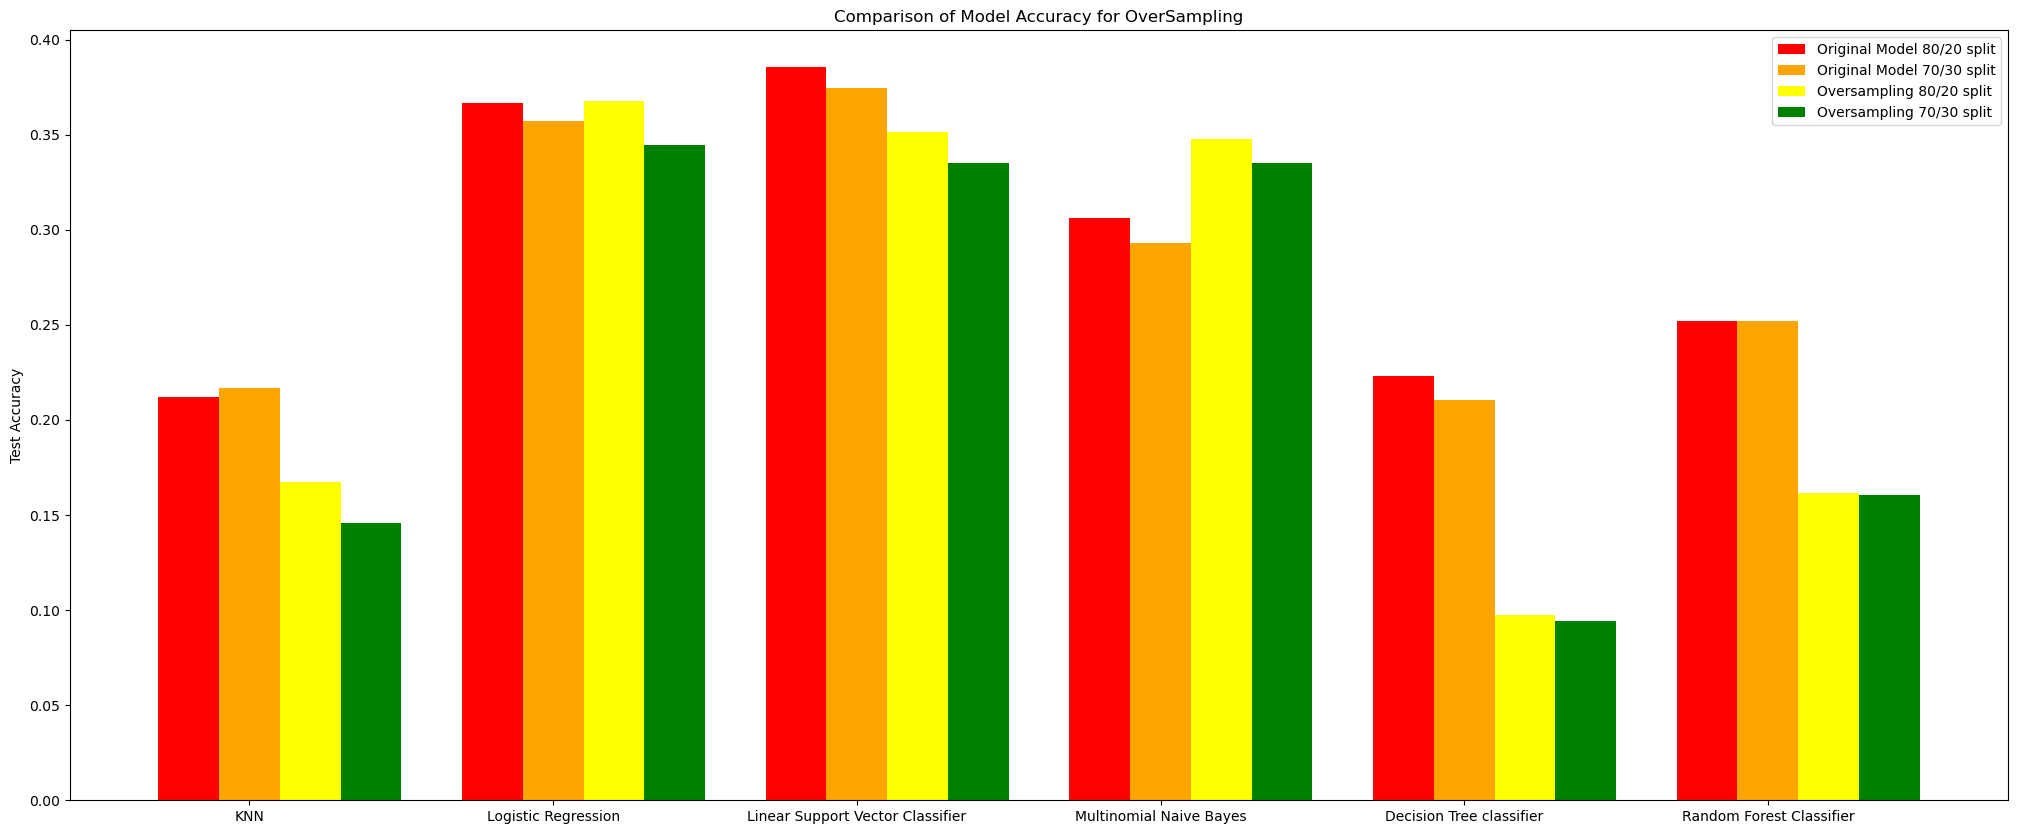

In [104]:
fig, ax = plt.subplots(figsize=(25, 10))
# Set width of each bar
bar_width = 0.2
models = model_accuracy_orig2['Models']
# Set position of bars on X axis
r1 = np.arange(len(model_accuracy_orig2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, model_accuracy_orig2['Test accuracy'], color='red', width=bar_width, label='Original Model 80/20 split')
plt.bar(r2, model_accuracy_orig3['Test accuracy'], color='orange', width=bar_width, label='Original Model 70/30 split')
plt.bar(r3, model_accuracy_over2['Test accuracy'], color='yellow', width=bar_width, label='Oversampling 80/20 split')
plt.bar(r4, model_accuracy_over3['Test accuracy'], color='green', width=bar_width, label='Oversampling 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(models))], models)

# Add y axis label and title
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Accuracy for OverSampling')

# Add legend
plt.legend()

# Show plot
plt.show()


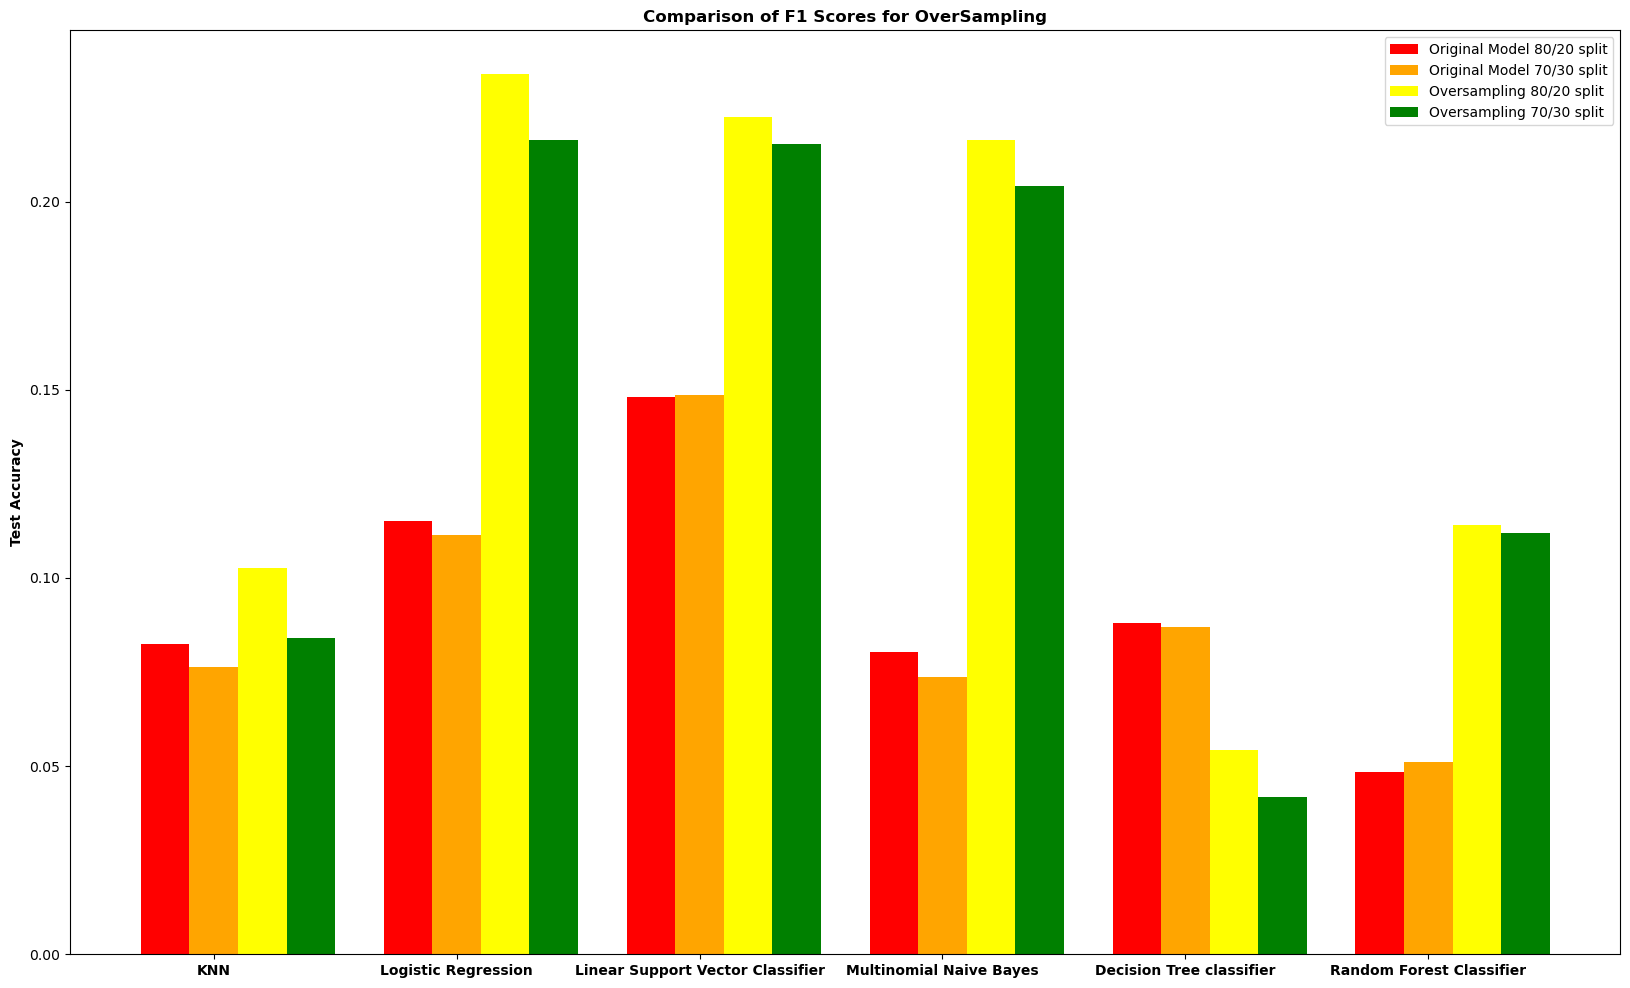

In [105]:
fig, ax = plt.subplots(figsize=(20, 12))
# Set width of each bar
bar_width = 0.2
models = f1_orig2['Models']
# Set position of bars on X axis
r1 = np.arange(len(f1_orig2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, f1_orig2['Test F1 Score'], color='red', width=bar_width, label='Original Model 80/20 split')
plt.bar(r2, f1_orig3['Test F1 Score'], color='orange', width=bar_width, label='Original Model 70/30 split')
plt.bar(r3, f1_over2['Test F1 Score'], color='yellow', width=bar_width, label='Oversampling 80/20 split')
plt.bar(r4, f1_over3['Test F1 Score'], color='green', width=bar_width, label='Oversampling 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(models))], models,fontweight='bold')

# Add y axis label and title
plt.ylabel('Test Accuracy',fontweight='bold')
plt.title('Comparison of F1 Scores for OverSampling',fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()


# 3. SMOTE ( Synthetic Minority Over-sampling Technique)

In [106]:
smote = SMOTE(sampling_strategy='minority')
smote

SMOTE(sampling_strategy='minority')

In [107]:
X_train2_temp = X_train2
y_train2_temp = y_train2
for i in range(15):
    X_train_sm2, y_train_sm2 = smote.fit_resample(X_train2_temp,y_train2_temp)   
    X_train2_temp = X_train_sm2
    y_train2_temp = y_train_sm2

In [108]:
X_train2.shape

(6940, 5000)

In [109]:
X_train_sm2.shape

(23456, 5000)

In [110]:
pd.DataFrame(y_train2)[0].value_counts()

9     1466
8     1176
11    1043
10     873
3      548
1      540
15     270
13     217
2      185
14     164
0      152
12     133
7       71
5       38
4       33
6       31
Name: 0, dtype: int64

In [111]:
pd.DataFrame(y_train_sm2)[0].value_counts()

15    1466
8     1466
9     1466
10    1466
3     1466
11    1466
1     1466
13    1466
7     1466
14    1466
2     1466
12    1466
4     1466
6     1466
5     1466
0     1466
Name: 0, dtype: int64

In [112]:
model_accuracy_smote2, report_smote2, f1_smote2 = model(X_train_sm2, X_test2, y_train_sm2, y_test2, target_names_orig)
model_accuracy_smote2.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


,Models,Test accuracy
0,Logistic Regression,0.379251
1,Linear Support Vector Classifier,0.367147
2,Multinomial Naive Bayes,0.345245
3,Random Forest Classifier,0.253602
4,Decision Tree classifier,0.144669
5,KNN,0.065130


In [113]:
f1_smote2.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Linear Support Vector Classifier,0.244522
1,Logistic Regression,0.230932
2,Multinomial Naive Bayes,0.208334
3,Random Forest Classifier,0.125991
4,Decision Tree classifier,0.067833
5,KNN,0.061371


## For 70/30

In [114]:
X_train3_temp = X_train3
y_train3_temp = y_train3
for i in range(15):
    X_train_sm3, y_train_sm3 = smote.fit_resample(X_train3_temp,y_train3_temp)   
    X_train3_temp = X_train_sm3
    y_train3_temp = y_train_sm3

In [115]:
X_train3.shape

(6072, 5000)

In [116]:
X_train_sm3.shape

(20512, 5000)

In [117]:
pd.DataFrame(y_train3)[0].value_counts()

9     1282
8     1029
11     913
10     764
3      479
1      472
15     236
13     190
2      162
14     144
0      133
12     116
7       62
5       34
4       29
6       27
Name: 0, dtype: int64

In [118]:
pd.DataFrame(y_train_sm3)[0].value_counts()

3     1282
8     1282
7     1282
10    1282
9     1282
11    1282
15    1282
0     1282
12    1282
1     1282
2     1282
14    1282
13    1282
5     1282
4     1282
6     1282
Name: 0, dtype: int64

In [119]:
model_accuracy_smote3, report_smote3, f1_smote3 = model(X_train_sm3, X_test3, y_train_sm3, y_test3, target_names_orig)
model_accuracy_smote3.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


,Models,Test accuracy
0,Logistic Regression,0.367269
1,Linear Support Vector Classifier,0.348828
2,Multinomial Naive Bayes,0.332693
3,Random Forest Classifier,0.215136
4,Decision Tree classifier,0.184403
5,KNN,0.063773


In [120]:
f1_smote3.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Logistic Regression,0.222453
1,Linear Support Vector Classifier,0.215916
2,Multinomial Naive Bayes,0.204516
3,Random Forest Classifier,0.103541
4,Decision Tree classifier,0.066501
5,KNN,0.060752


# Model Comparison For 16 Personality Traits

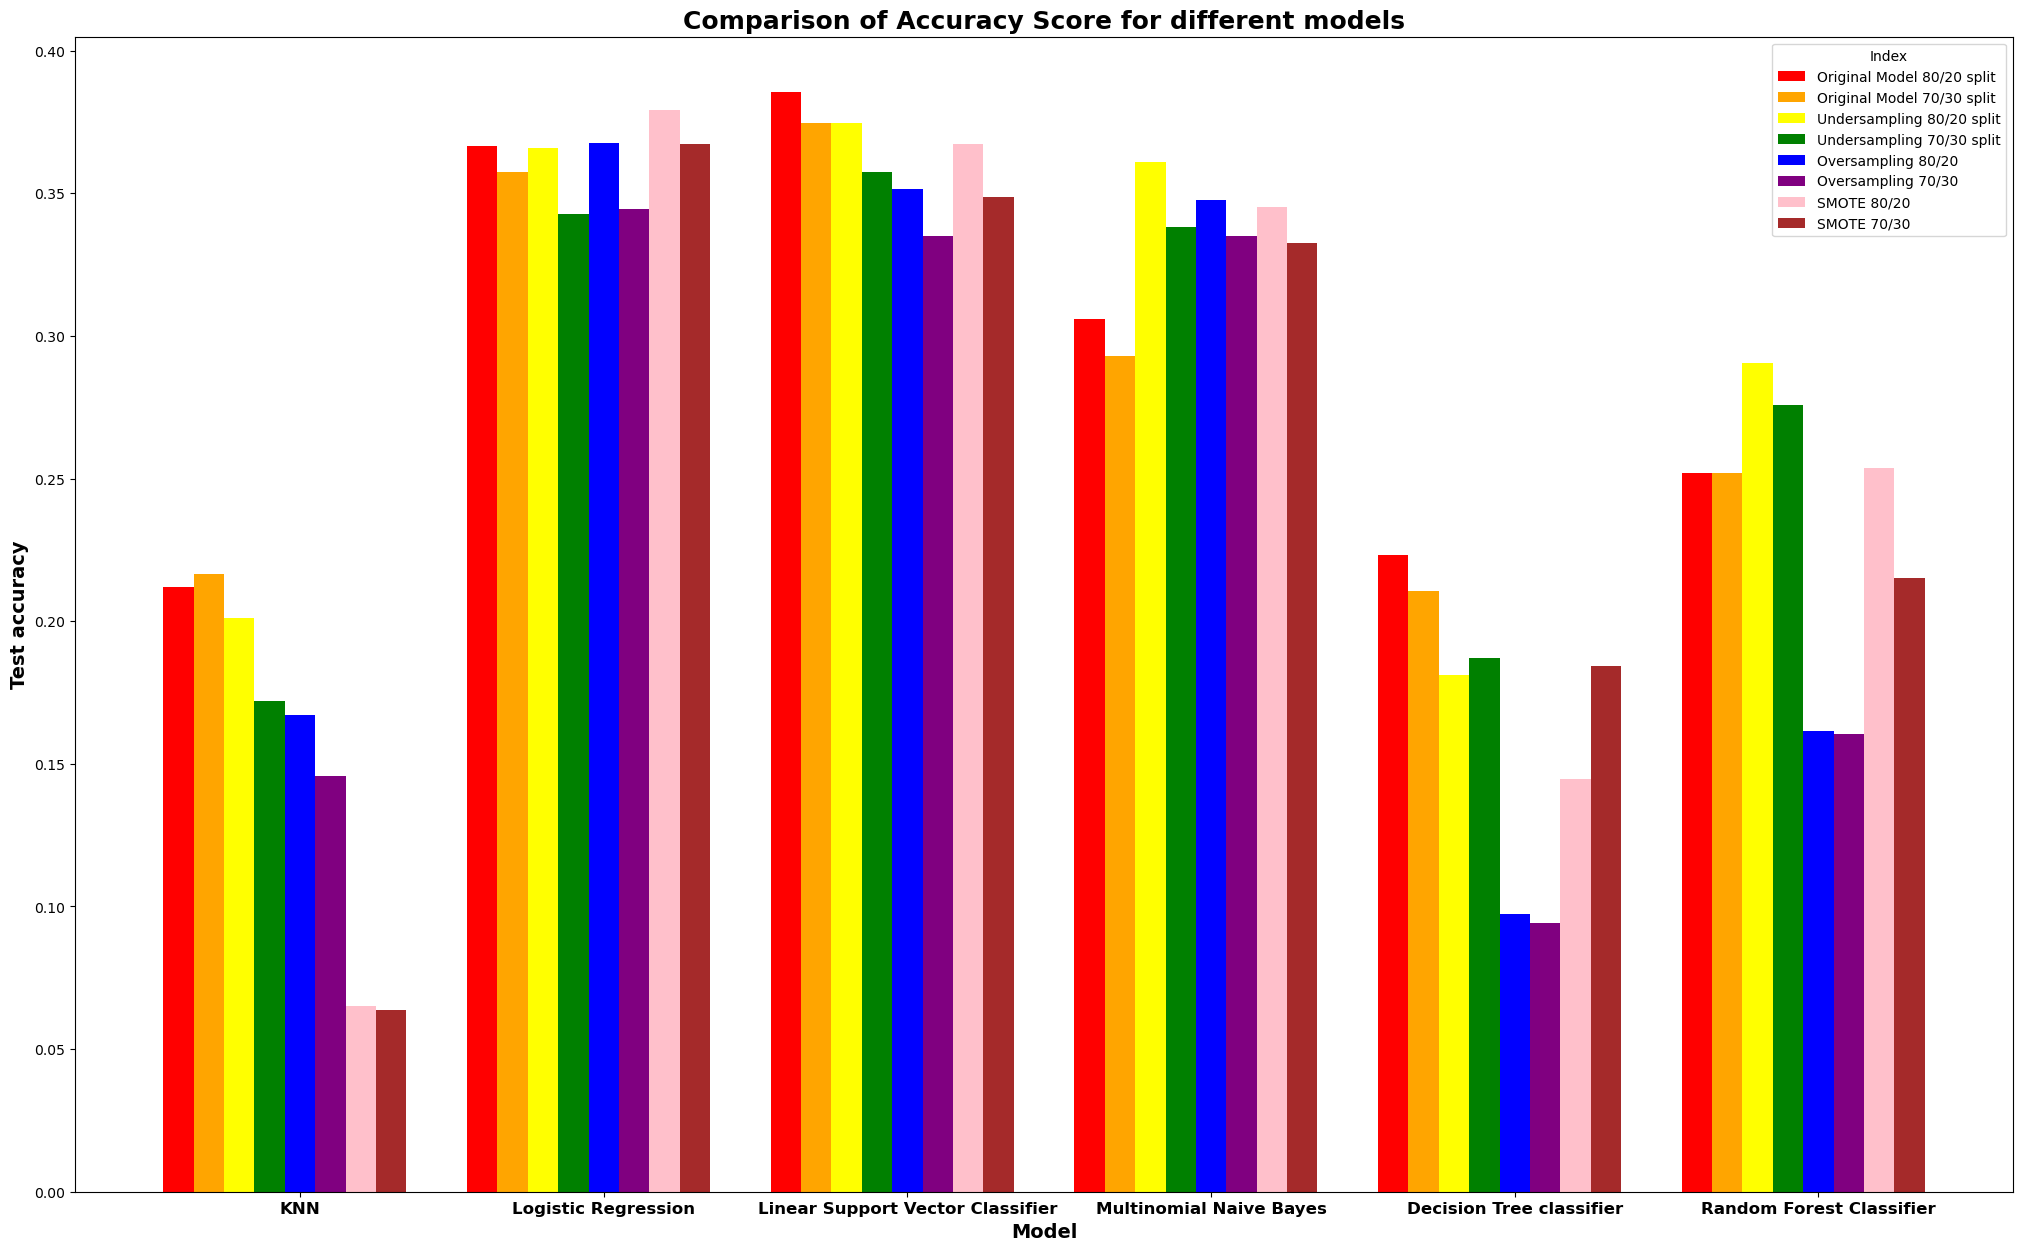

In [121]:
import matplotlib.pyplot as plt

# create a bar plot for test accuracy
fig, ax = plt.subplots(figsize=(25, 15))
width = 0.1
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown']
name = ['Original Model 80/20 split', 'Original Model 70/30 split', 'Undersampling 80/20 split', 'Undersampling 70/30 split','Oversampling 80/20', 'Oversampling 70/30',
        'SMOTE 80/20', 'SMOTE 70/30']
accuracies = [model_accuracy_orig2, model_accuracy_orig3, model_accuracy_under2, model_accuracy_under3, model_accuracy_over2, model_accuracy_over3, model_accuracy_smote2, model_accuracy_smote3]
for i in range(len(accuracies)):
    ax.bar(x=np.arange(len(accuracies[i]['Models']))+i*width, height=accuracies[i]['Test accuracy'], width=width, color=colors[i], label=f"{name[i]}")
ax.set_ylabel('Test accuracy', fontweight='bold', fontsize=14)
ax.set_xlabel('Model', fontweight='bold', fontsize=14)
ax.set_title('Comparison of Accuracy Score for different models', fontweight='bold', fontsize=18)
ax.set_xticks(np.arange(len(model_accuracy_orig2['Models']))+width*4)
ax.set_xticklabels(model_accuracy_orig2['Models'], fontweight='bold', fontsize=12)
ax.legend(title="Index")
plt.show()


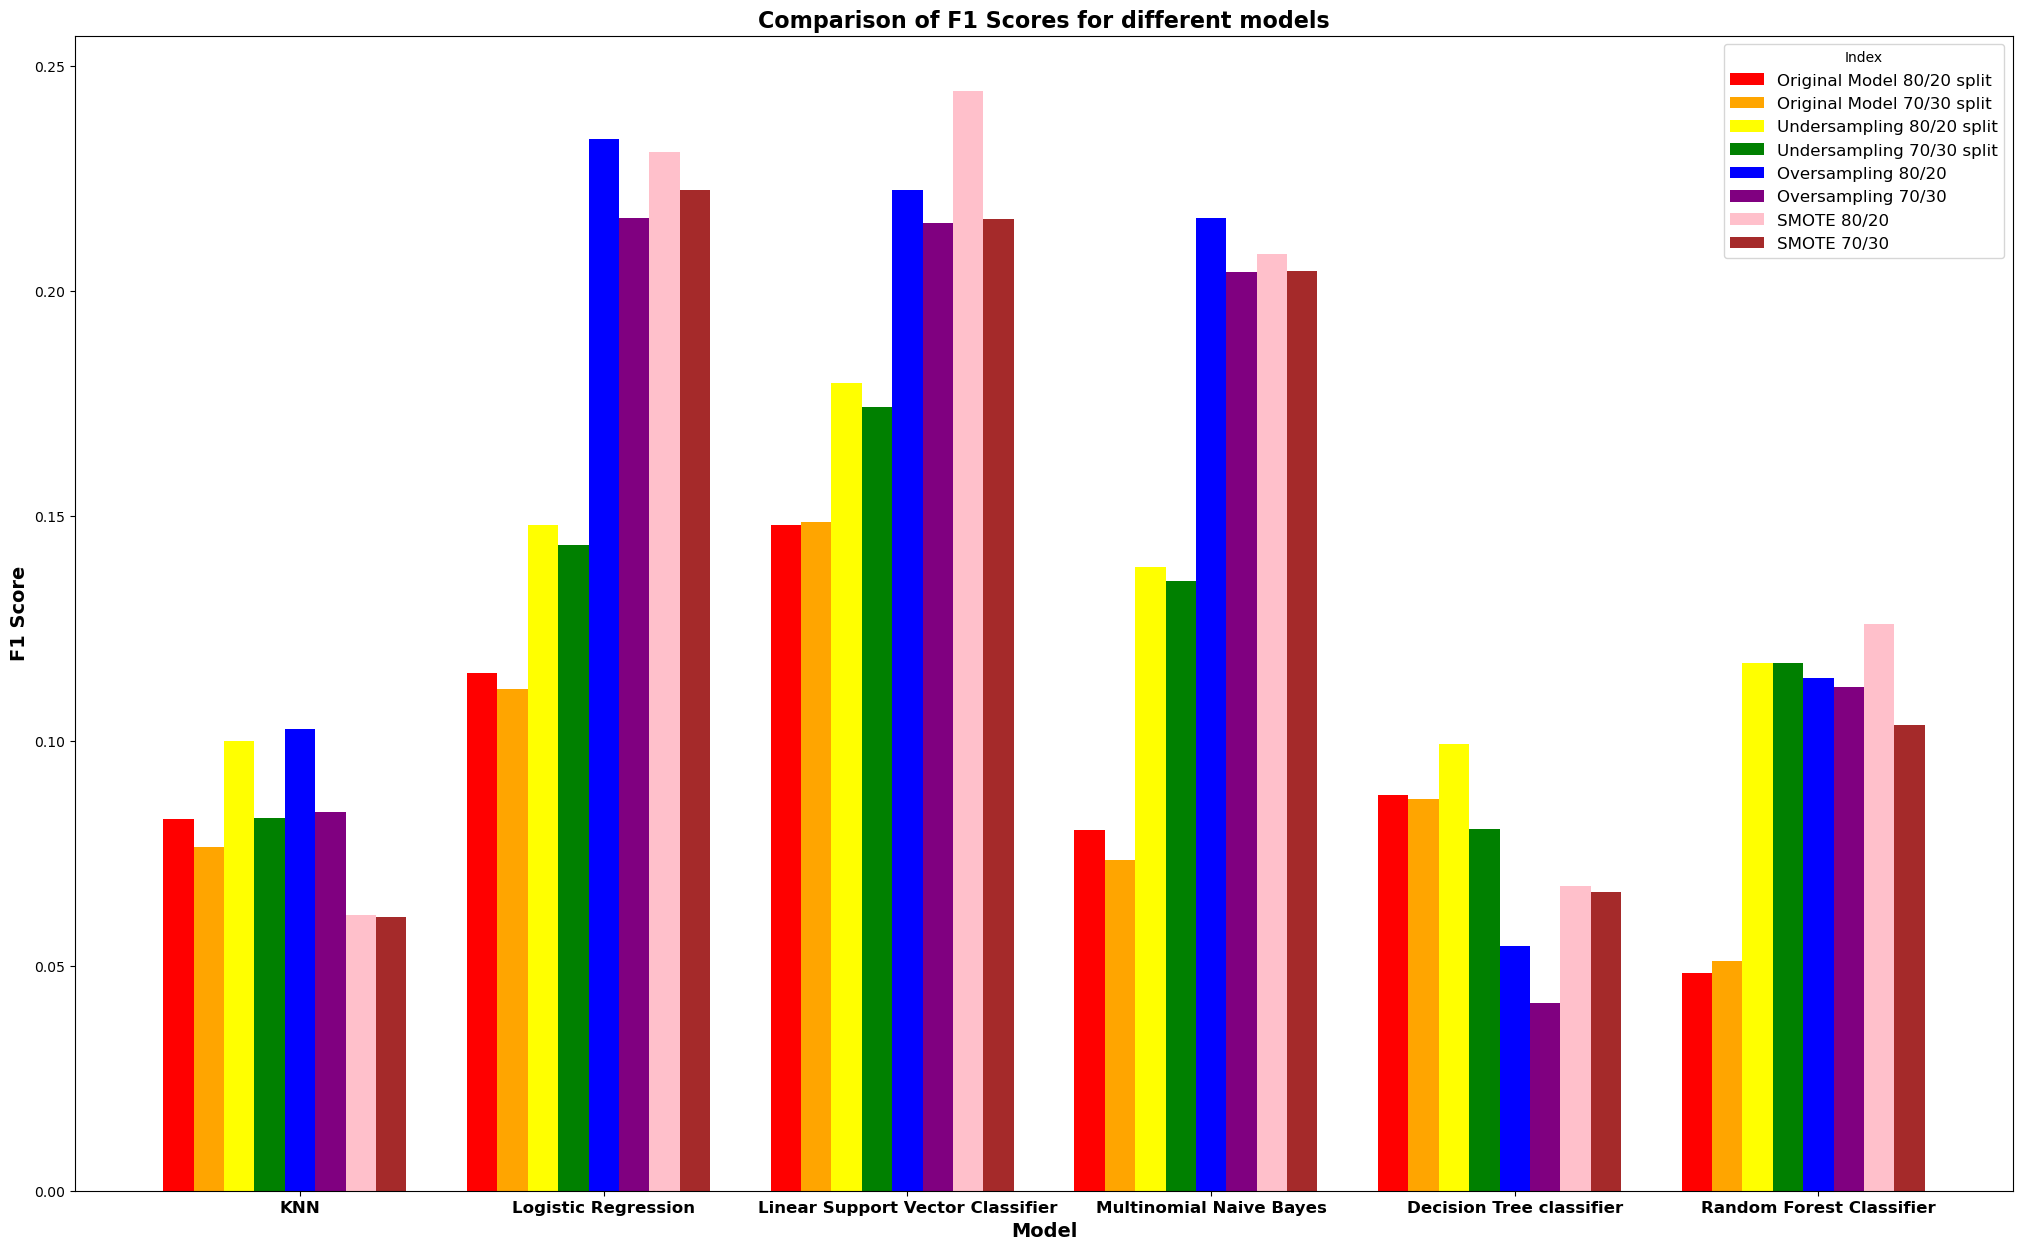

In [122]:
fig, ax = plt.subplots(figsize=(25, 15))
width = 0.1
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown']
name = ['Original Model 80/20 split', 'Original Model 70/30 split', 'Undersampling 80/20 split', 'Undersampling 70/30 split','Oversampling 80/20', 'Oversampling 70/30',
        'SMOTE 80/20', 'SMOTE 70/30']
accuracies = [f1_orig2, f1_orig3, f1_orig_under2, f1_orig_under3, f1_over2, f1_over3, f1_smote2, f1_smote3]
for i in range(len(accuracies)):
    ax.bar(x=np.arange(len(accuracies[i]['Models']))+i*width, height=accuracies[i]['Test F1 Score'], width=width, color=colors[i], label=f"{name[i]}")
ax.set_ylabel('F1 Score', fontweight='bold', fontsize=14)
ax.set_xlabel('Model', fontweight='bold', fontsize=14)
ax.set_title('Comparison of F1 Scores for different models', fontweight='bold', fontsize=16)
ax.set_xticks(np.arange(len(f1_orig2['Models']))+width*4)
ax.set_xticklabels(f1_orig2['Models'], fontweight='bold', fontsize=12)
ax.legend(title="Index", fontsize=12)
plt.show()


# Conclusion: Logistic Regression For Oversampling 80/20 split, gives the highest accuracy

# Since even Handling Imbalance techniques are also not performing very well on this dataset, we will club the 4 personality traits to have only 4 classes

# 4 Personality Types

In [123]:
df2 = df.replace(['INTJ', 'INTP', 'ENTJ', 'ENTP' ], 'Analysts')

df2 = df2.replace(['INFJ', 'INFP', 'ENFJ', 'ENFP'], 'Diplomats')

df2 = df2.replace(['ISTJ', 'ISFJ', 'ESTJ', 'ESFJ'], 'Sentinels')

df2 = df2.replace(['ISTP', 'ISFP', 'ESTP', 'ESFP'], 'Explorers')

In [124]:
df2.head()

,type,posts,words_per_comment,variance_of_word_counts,length_posts
0,Diplomats,moments sportscenter top ten plays pranks life...,11.12,135.2900,4652
1,Analysts,finding lack posts alarming sex boring positio...,23.40,187.4756,7053
2,Analysts,good one course say know blessing curse absolu...,16.72,180.6900,5265
3,Analysts,dear enjoyed conversation day esoteric gabbing...,21.28,181.8324,6271
4,Analysts,fired another silly misconception approaching ...,19.34,196.4576,6111


In [125]:
df2.type.value_counts()

Diplomats    4167
Analysts     3311
Explorers     745
Sentinels     452
Name: type, dtype: int64

Text(0.5, 1.0, 'Total post each personality type')

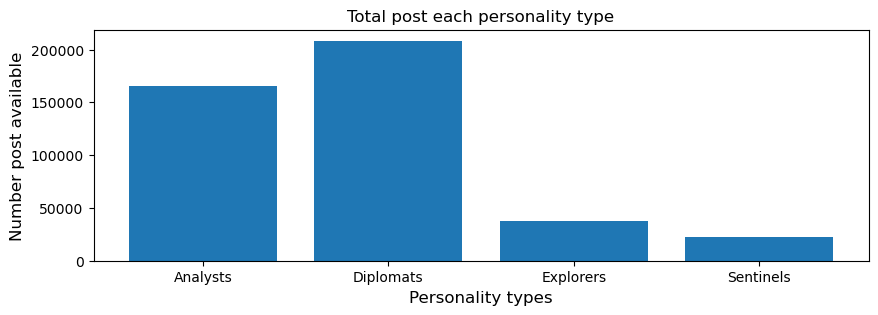

In [126]:
total_club = df2.groupby(['type']).count()*50
plt.figure(figsize = (10,3))
plt.bar(np.array(total_club.index), height =total_club['posts'],)
plt.xlabel('Personality types', size = 12)
plt.ylabel('Number post available', size = 12)
plt.title('Total post each personality type')

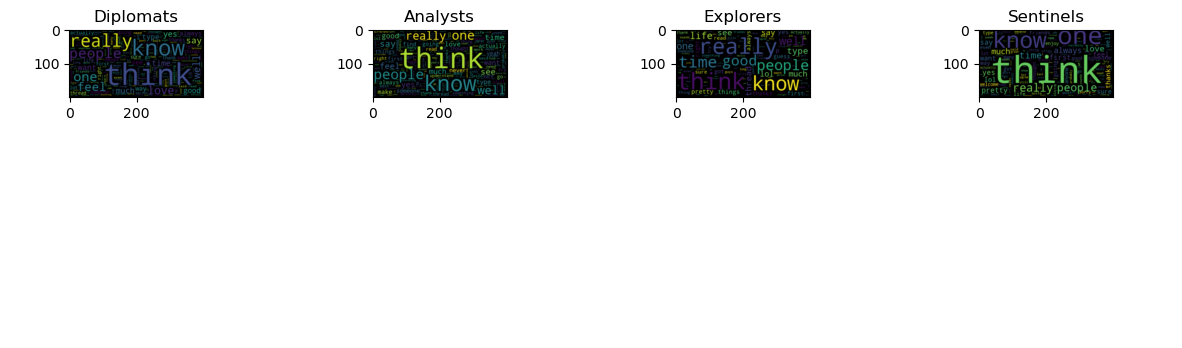

In [127]:
fig, ax = plt.subplots(len(df2['type'].unique()), figsize=(15,len(df2['type'].unique())))
k = 0
for i in df2['type'].unique():
    df_4 = df2[df2['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

In [128]:
target_encoder=LabelEncoder()
target_encoder.fit(df2.type)

LabelEncoder()

In [129]:
target_encoder.classes_

array(['Analysts', 'Diplomats', 'Explorers', 'Sentinels'], dtype=object)

In [130]:
target_encoder

LabelEncoder()

In [131]:
df2.type.value_counts()

Diplomats    4167
Analysts     3311
Explorers     745
Sentinels     452
Name: type, dtype: int64

In [132]:
np.unique(target_encoder.fit_transform(df2.type))

array([0, 1, 2, 3])

In [133]:
le_name_mapping = dict(zip(target_encoder.classes_, target_encoder.fit_transform(target_encoder.classes_)))
new_dict = dict([(value, key) for key, value in le_name_mapping.items()])
new_dict

{0: 'Analysts', 1: 'Diplomats', 2: 'Explorers', 3: 'Sentinels'}

In [134]:
# saving the models
'''import pickle

with open('dic_name.pkl', 'wb') as file:
    pickle.dump(new_dict, file)'''

"import pickle\n\nwith open('dic_name.pkl', 'wb') as file:\n    pickle.dump(new_dict, file)"

In [135]:
# For 80/20
X_train_club2, X_test_club2, y_train_club2, y_test_club2 = split(df2, 0.2)

# For 70/30
X_train_club3, X_test_club3, y_train_club3, y_test_club3 = split(df2, 0.3)

Cleaning The Dataset


100%|██████████| 8675/8675 [00:04<00:00, 1938.96it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.



Splitting into train & test
Applying Tfidf Vectorization
Label Encoding the classes
Getting the final train and test
['Analysts' 'Diplomats' 'Explorers' 'Sentinels']
Cleaning The Dataset


100%|██████████| 8675/8675 [00:04<00:00, 1934.33it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.



Splitting into train & test
Applying Tfidf Vectorization
Label Encoding the classes
Getting the final train and test
['Analysts' 'Diplomats' 'Explorers' 'Sentinels']


In [136]:
y_train_club2

array([1, 1, 0, ..., 1, 0, 0])

In [137]:
y_test_club3

array([1, 1, 0, ..., 0, 1, 0])

In [138]:
target_names_club = 4

In [139]:
model_accuracy_club2, report_orig2, f1_orig_club2 = model(X_train_club2, X_test_club2, y_train_club2, y_test_club2, target_names_club)
model_accuracy_club2.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


,Models,Test accuracy
0,Linear Support Vector Classifier,0.685879
1,Logistic Regression,0.681844
2,Multinomial Naive Bayes,0.639193
3,Random Forest Classifier,0.614409
4,Decision Tree classifier,0.536023
5,KNN,0.518732


In [140]:
f1_orig_club2.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Linear Support Vector Classifier,0.379771
1,Logistic Regression,0.377422
2,Multinomial Naive Bayes,0.336585
3,Random Forest Classifier,0.317131
4,Decision Tree classifier,0.313526
5,KNN,0.282678


## For 70/30

In [141]:
model_accuracy_club3, report_orig3, f1_orig_club3 = model(X_train_club3, X_test_club3, y_train_club3, y_test_club3, target_names_club)
model_accuracy_club3.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


,Models,Test accuracy
0,Logistic Regression,0.689205
1,Linear Support Vector Classifier,0.688052
2,Multinomial Naive Bayes,0.637342
3,Random Forest Classifier,0.606992
4,Decision Tree classifier,0.540914
5,KNN,0.519785


In [142]:
f1_orig_club3.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Linear Support Vector Classifier,0.374294
1,Logistic Regression,0.373395
2,Multinomial Naive Bayes,0.335365
3,Decision Tree classifier,0.320482
4,Random Forest Classifier,0.312117
5,KNN,0.271211


## Performance Visualisation

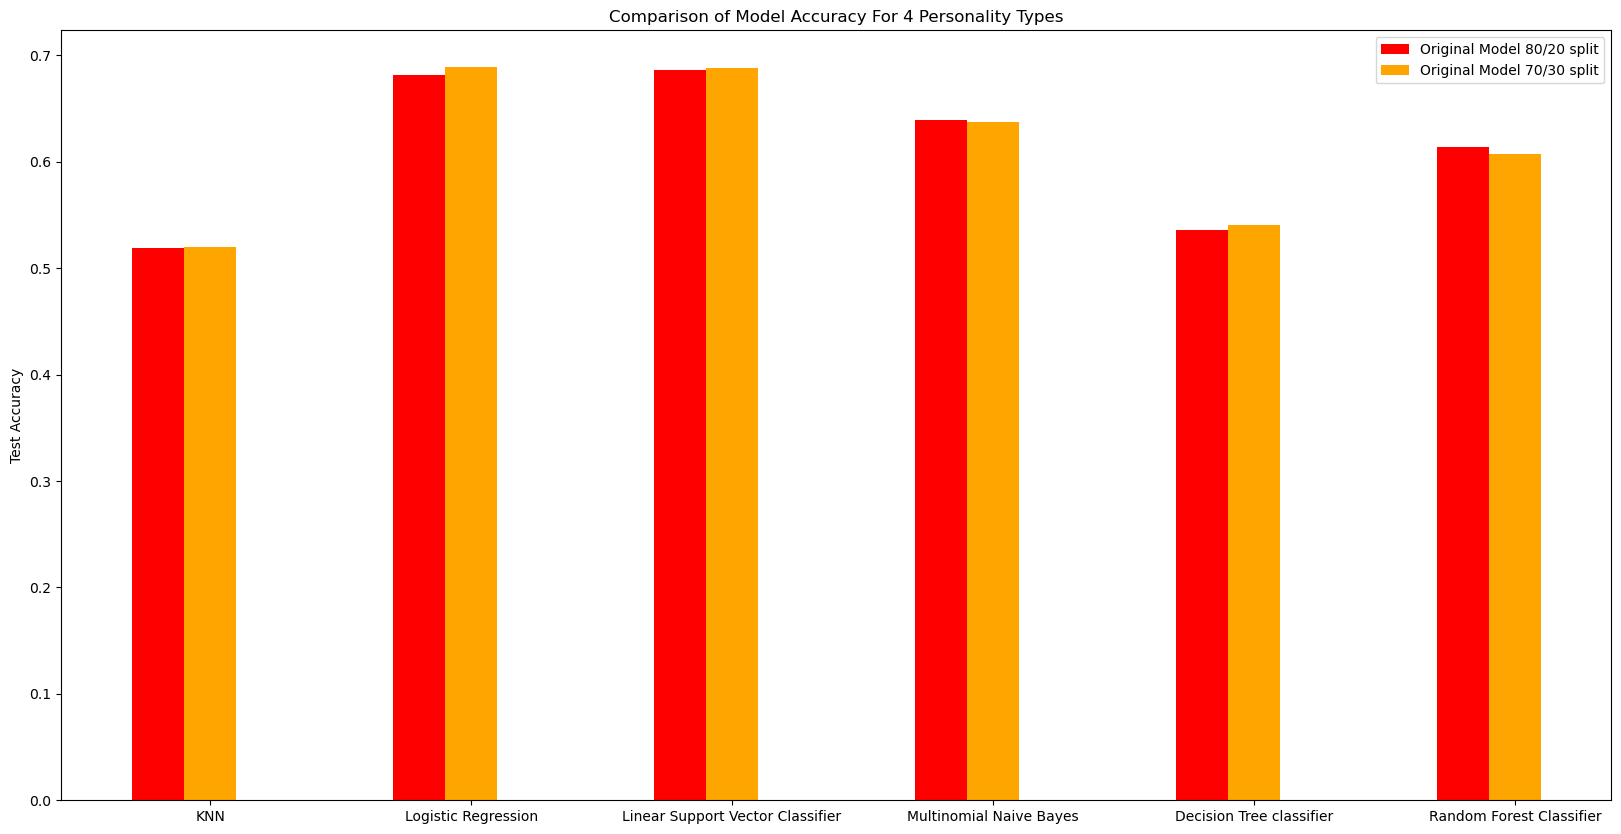

In [143]:
fig, ax = plt.subplots(figsize=(20, 10))
# Set width of each bar
bar_width = 0.2
models = model_accuracy_club2['Models']
# Set position of bars on X axis
r1 = np.arange(len(model_accuracy_club2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, model_accuracy_club2['Test accuracy'], color='red', width=bar_width, label='Original Model 80/20 split')
plt.bar(r2, model_accuracy_club3['Test accuracy'], color='orange', width=bar_width, label='Original Model 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(models))], models)

# Add y axis label and title
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Accuracy For 4 Personality Types')

# Add legend
plt.legend()

# Show plot
plt.show()


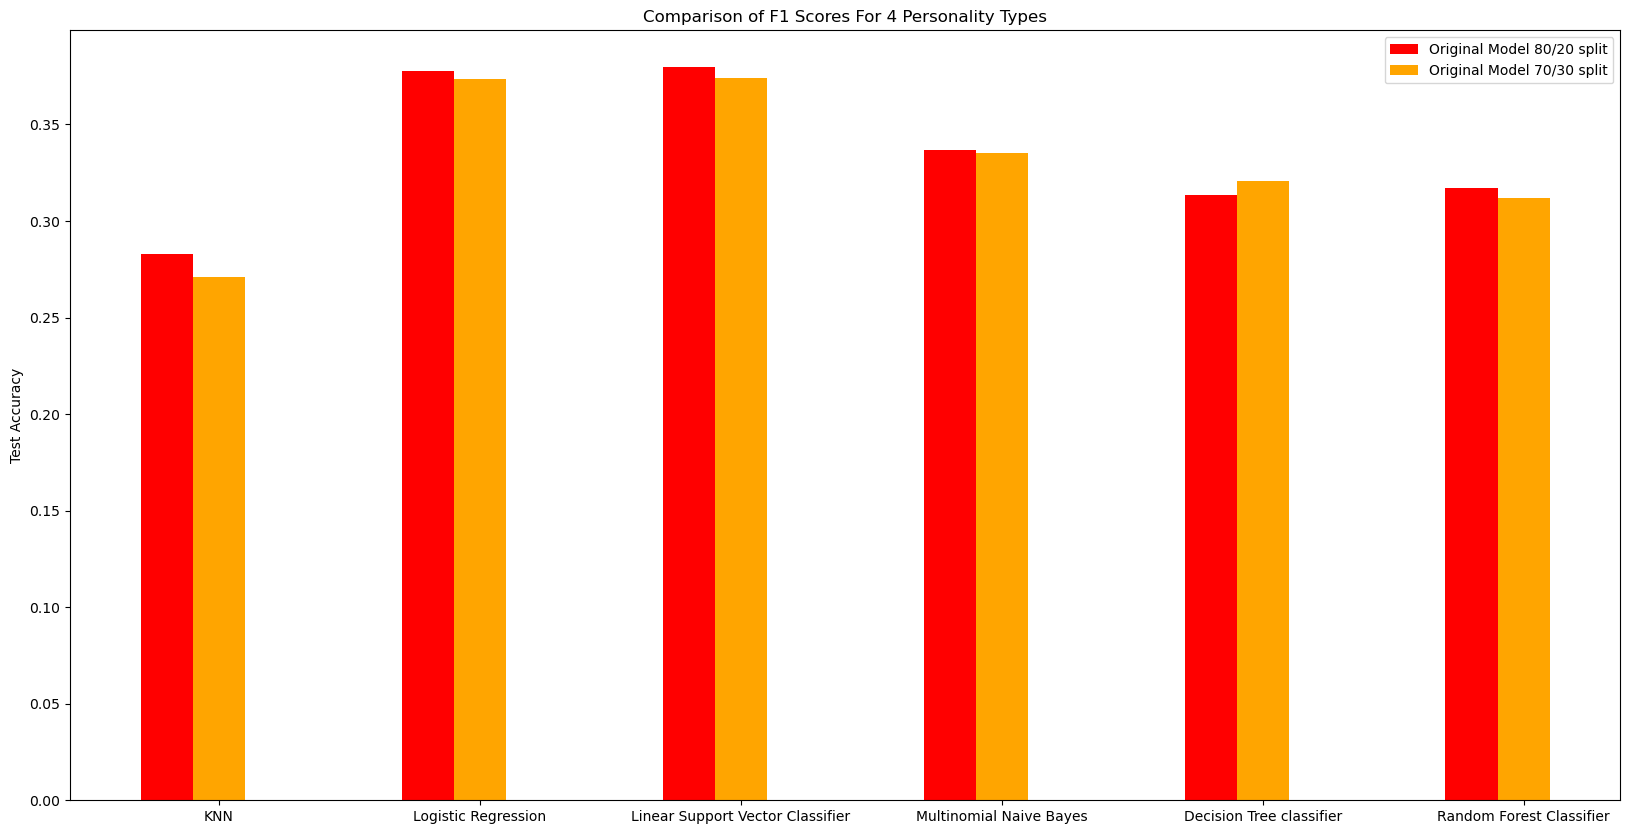

In [144]:
fig, ax = plt.subplots(figsize=(20, 10))
# Set width of each bar
bar_width = 0.2
models = f1_orig_club2['Models']
# Set position of bars on X axis
r1 = np.arange(len(f1_orig_club2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, f1_orig_club2['Test F1 Score'], color='red', width=bar_width, label='Original Model 80/20 split')
plt.bar(r2, f1_orig_club3['Test F1 Score'], color='orange', width=bar_width, label='Original Model 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(models))], models)

# Add y axis label and title
plt.ylabel('Test Accuracy')
plt.title('Comparison of F1 Scores For 4 Personality Types')

# Add legend
plt.legend()

# Show plot
plt.show()


## Comparison of F1-Score For 4 Personality vs 16 Personalities

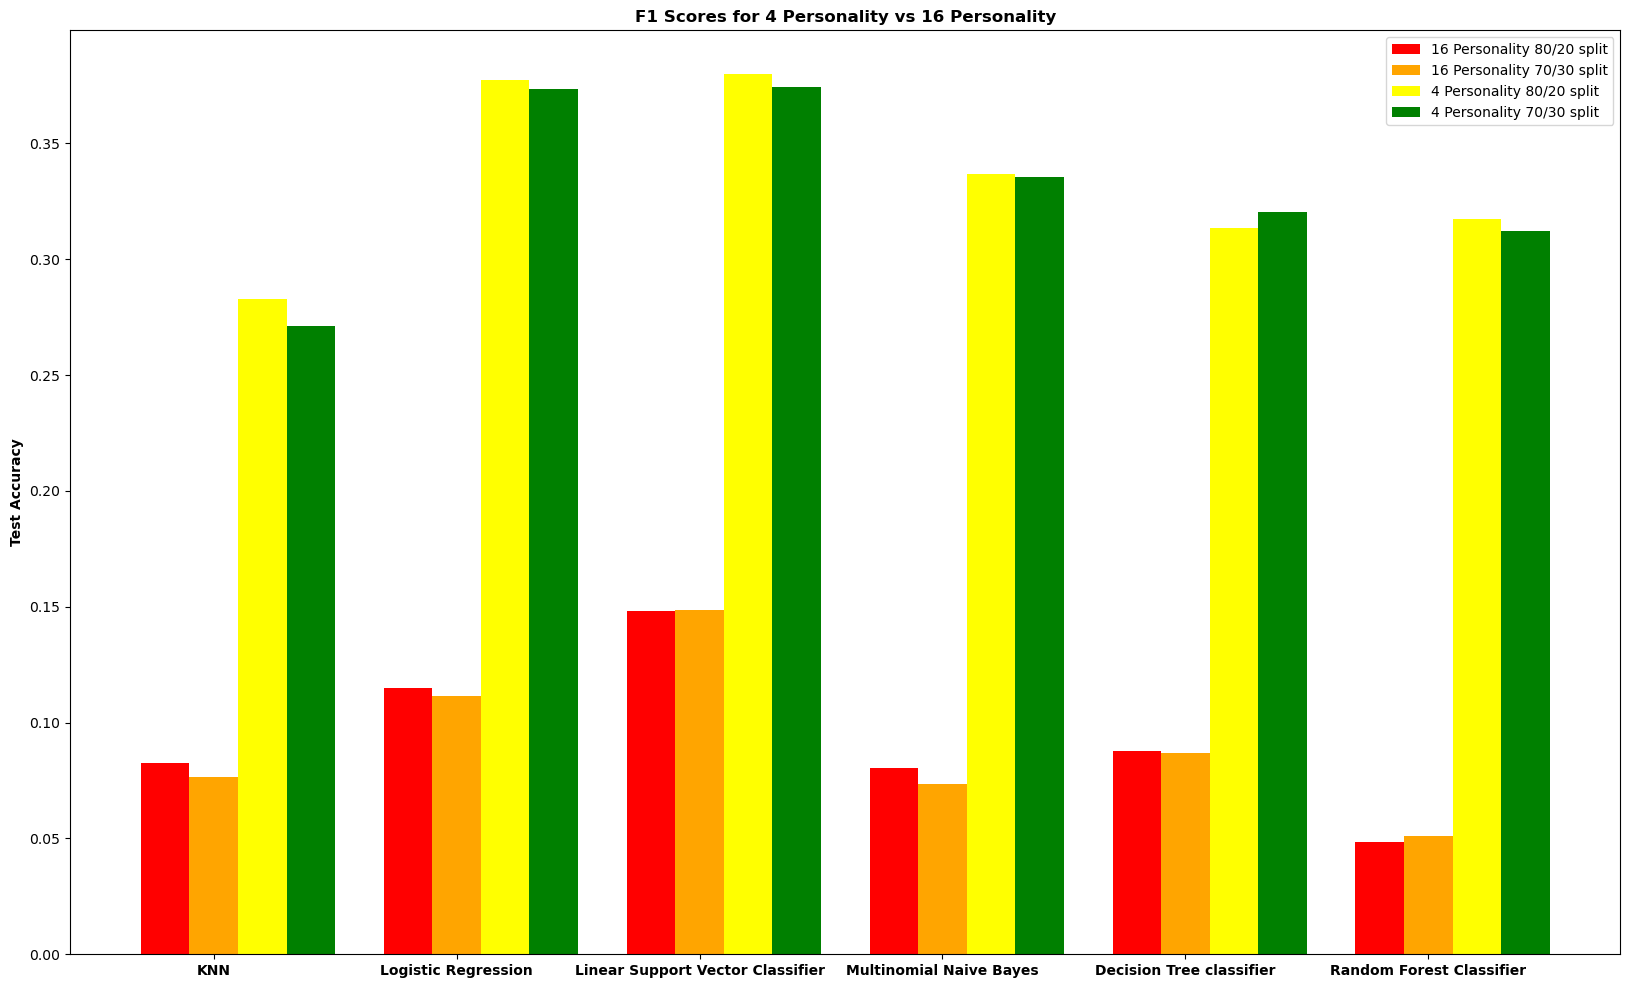

In [145]:
fig, ax = plt.subplots(figsize=(20, 12))
# Set width of each bar
bar_width = 0.2
models = f1_orig2['Models']
# Set position of bars on X axis
r1 = np.arange(len(f1_orig2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, f1_orig2['Test F1 Score'], color='red', width=bar_width, label='16 Personality 80/20 split')
plt.bar(r2, f1_orig3['Test F1 Score'], color='orange', width=bar_width, label='16 Personality 70/30 split')
plt.bar(r3, f1_orig_club2['Test F1 Score'], color='yellow', width=bar_width, label='4 Personality 80/20 split')
plt.bar(r4, f1_orig_club3['Test F1 Score'], color='green', width=bar_width, label='4 Personality 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(models))], models,fontweight='bold')

# Add y axis label and title
plt.ylabel('Test Accuracy',fontweight='bold')
plt.title('F1 Scores for 4 Personality vs 16 Personality',fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()


# Preprocessing Techniques

In [146]:
train_data_club2 = pd.DataFrame({'posts': list(X_train_club2), 'type': list(y_train_club2)}, index=None)
train_data_club2

,posts,type
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08446016...",1
2,"[0.0, 0.033900492870677146, 0.0, 0.0, 0.0, 0.0...",0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
6935,"[0.0, 0.027889277754642644, 0.0, 0.0, 0.0, 0.0...",0
6936,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
6937,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
6938,"[0.0, 0.03006164632721285, 0.0, 0.0, 0.0, 0.0,...",0


In [147]:
train_data_club3 = pd.DataFrame({'posts': list(X_train_club3), 'type': list(y_train_club3)}, index=None)
train_data_club3

,posts,type
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,"[0.0, 0.03315117835389844, 0.0, 0.0, 0.0, 0.0,...",0
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
...,...,...
6067,"[0.0, 0.028233275110124897, 0.0, 0.0, 0.0, 0.0...",0
6068,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
6069,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
6070,"[0.0, 0.030292717588630502, 0.0, 0.0, 0.0, 0.0...",0


In [148]:
print("For 80/20 split: ")
train_data_club2.type.value_counts()

For 80/20 split: 


1    3333
0    2649
2     596
3     362
Name: type, dtype: int64

In [149]:
print("For 70/30 split: ")
train_data_club3.type.value_counts()

For 70/30 split: 


1    2917
0    2318
2     521
3     316
Name: type, dtype: int64

## We will keep  'X_test_club2' & 'y_test_club2' for testing 3 techniques, since it is very important to keep the test data pure

# 1. Undersampling

## For 80/20 split

### We will Take 1500 samples

In [150]:
cls_nm = [1, 0]

In [151]:
train_data_club_under2 = sampling('under', train_data_club2, 'type', cls_nm, 1500)
train_data_club_under2

,posts,type
3752,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
5971,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
438,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3356,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
6899,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
6902,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
6905,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
6907,"[0.05880035959071519, 0.0, 0.0, 0.0, 0.0, 0.0,...",2


In [152]:
train_data_club_under2.type.value_counts()

1    1500
0    1500
2     596
3     362
Name: type, dtype: int64

In [153]:
X_train_under_club2, y_train_under_club2 = get_train(train_data_club_under2)

In [154]:
X_train_under_club2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.1239544 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05880036, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [155]:
y_train_under_club2

array([1, 1, 1, ..., 2, 2, 3])

In [156]:
print(X_train_under_club2.shape, X_test_club2.shape)

(3958, 5000) (1735, 5000)


In [157]:
print(y_train_under_club2.shape, y_test_club2.shape)

(3958,) (1735,)


In [158]:
model_accuracy_under_club2, report_under_club2, f1_under_club2 = model(X_train_under_club2, X_test_club2, y_train_under_club2, y_test_club2, target_names_club)
model_accuracy_under_club2.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


,Models,Test accuracy
0,Linear Support Vector Classifier,0.673775
1,Logistic Regression,0.669164
2,Multinomial Naive Bayes,0.651297
3,Random Forest Classifier,0.628242
4,KNN,0.514121
5,Decision Tree classifier,0.493372


In [159]:
f1_under_club2.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Linear Support Vector Classifier,0.392049
1,Logistic Regression,0.384022
2,Multinomial Naive Bayes,0.352953
3,Random Forest Classifier,0.335870
4,Decision Tree classifier,0.317478
5,KNN,0.299848


## For 70/30 split

### We will take 1000 samples

In [160]:
train_data_club3.type.value_counts()

1    2917
0    2318
2     521
3     316
Name: type, dtype: int64

In [161]:
train_data_club_under3 = sampling('under', train_data_club3, 'type', cls_nm, 1000)
train_data_club_under3

,posts,type
131,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
32,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
55,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2303,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2527,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
6042,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
6054,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
6055,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
6063,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


In [162]:
train_data_club_under3.type.value_counts()

1    1000
0    1000
2     521
3     316
Name: type, dtype: int64

In [163]:
X_train_under_club3, y_train_under_club3 = get_train(train_data_club_under3)

In [164]:
X_train_under_club3

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05359676,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [165]:
y_train_under_club3

array([1, 1, 1, ..., 3, 2, 2])

In [166]:
print(X_train_under_club3.shape, X_test_club3.shape)

(2837, 5000) (2603, 5000)


In [167]:
print(y_train_under_club3.shape, y_test_club3.shape)

(2837,) (2603,)


In [168]:
model_accuracy_under_club3, report_under_club3, f1_under_club3 = model(X_train_under_club3, X_test_club3, y_train_under_club3, y_test_club3, target_names_club)
model_accuracy_under_club3.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


,Models,Test accuracy
0,Linear Support Vector Classifier,0.682674
1,Logistic Regression,0.680369
2,Multinomial Naive Bayes,0.651172
3,Random Forest Classifier,0.636573
4,KNN,0.511333
5,Decision Tree classifier,0.470995


In [169]:
f1_under_club3.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Linear Support Vector Classifier,0.423359
1,Logistic Regression,0.410781
2,Multinomial Naive Bayes,0.350752
3,Random Forest Classifier,0.340791
4,Decision Tree classifier,0.338373
5,KNN,0.292027


# Performance Evaluation For UnderSampling

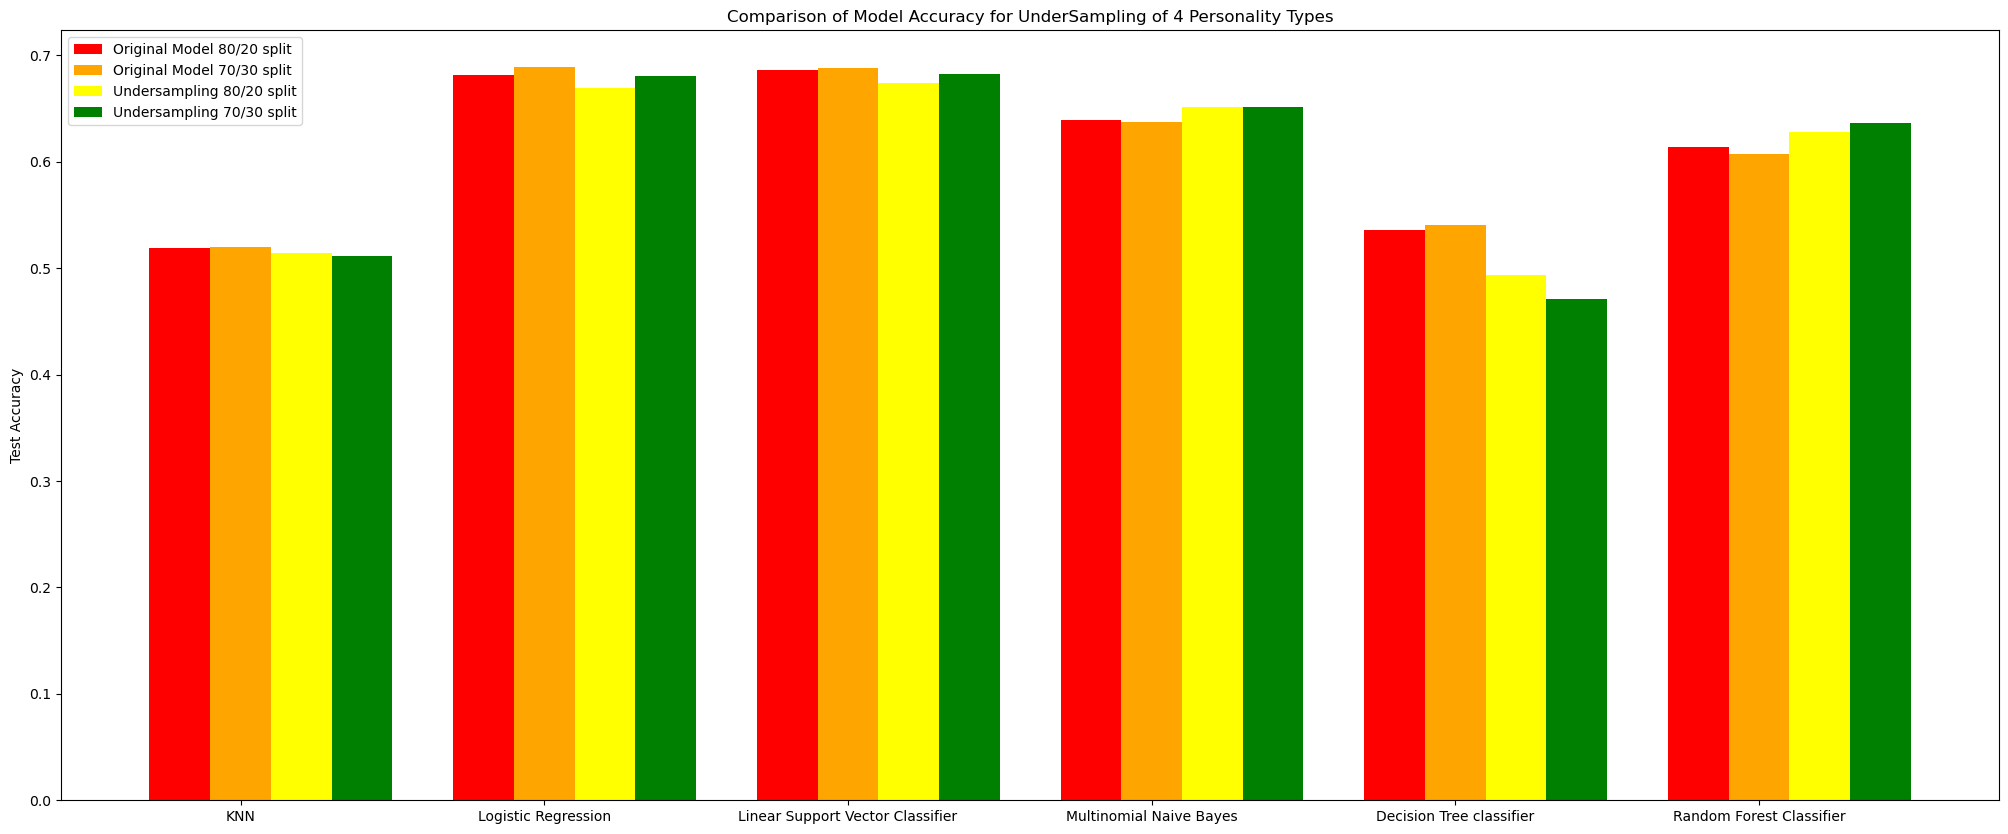

In [170]:
fig, ax = plt.subplots(figsize=(25, 10))
# Set width of each bar
bar_width = 0.2
models = model_accuracy_club2['Models']
# Set position of bars on X axis
r1 = np.arange(len(model_accuracy_club2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, model_accuracy_club2['Test accuracy'], color='red', width=bar_width, label='Original Model 80/20 split')
plt.bar(r2, model_accuracy_club3['Test accuracy'], color='orange', width=bar_width, label='Original Model 70/30 split')
plt.bar(r3, model_accuracy_under_club2['Test accuracy'], color='yellow', width=bar_width, label='Undersampling 80/20 split')
plt.bar(r4, model_accuracy_under_club3['Test accuracy'], color='green', width=bar_width, label='Undersampling 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(models))], models)

# Add y axis label and title
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Accuracy for UnderSampling of 4 Personality Types')

# Add legend
plt.legend()

# Show plot
plt.show()


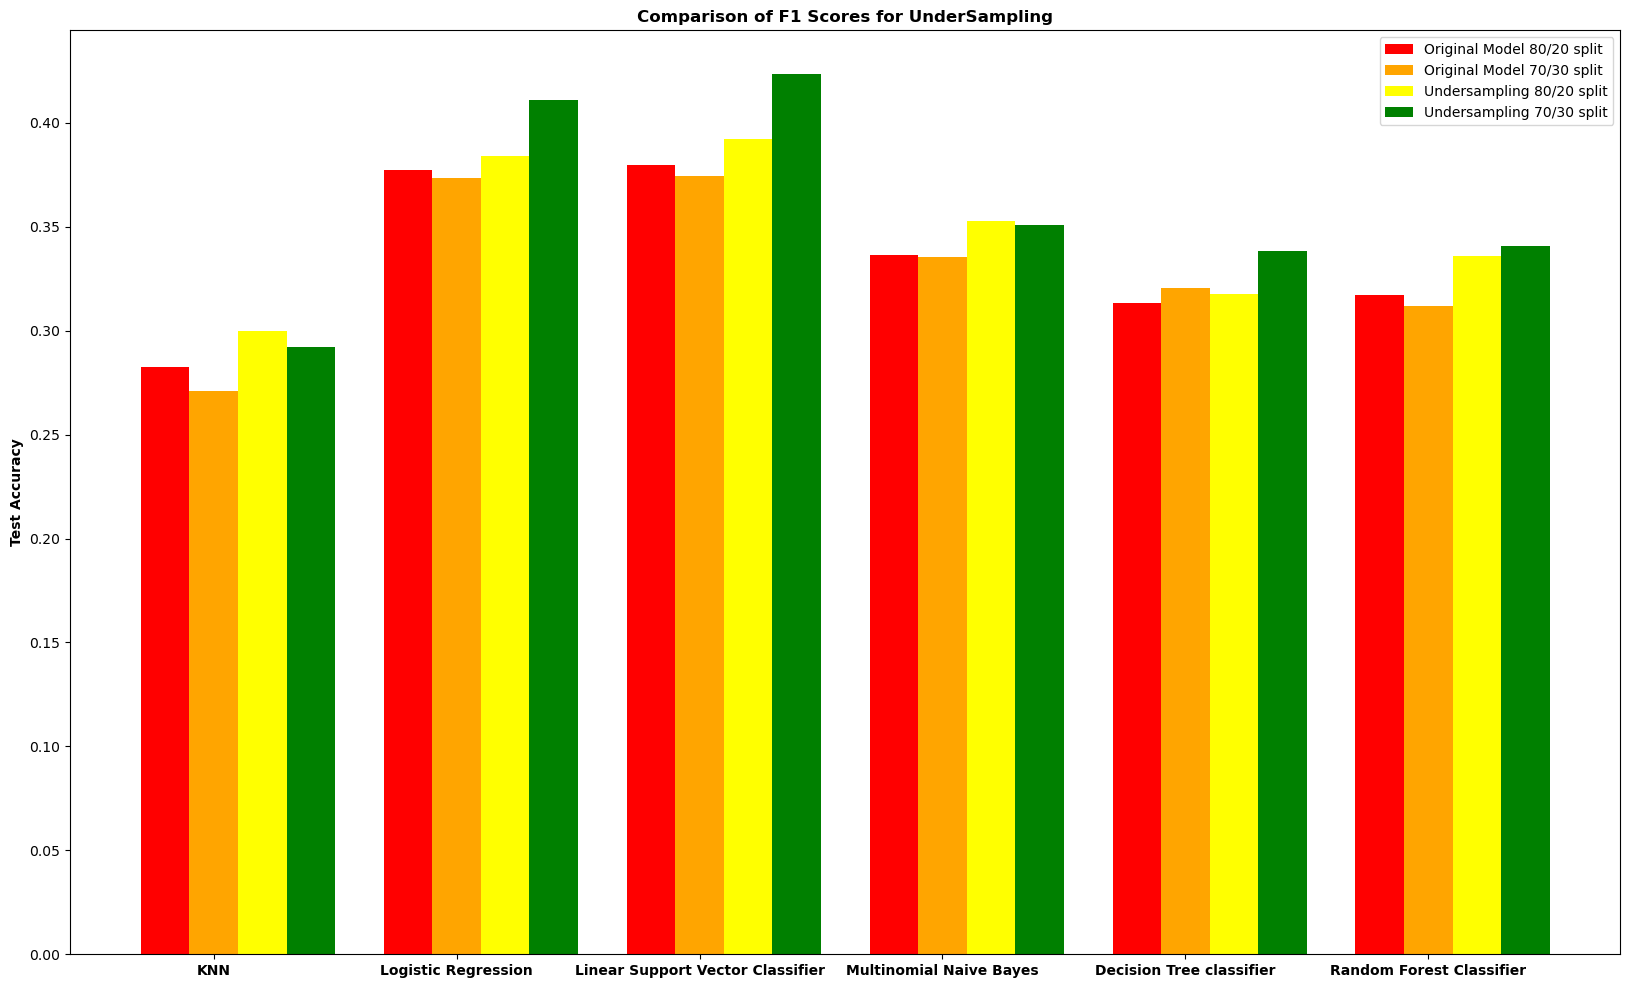

In [171]:
fig, ax = plt.subplots(figsize=(20, 12))
# Set width of each bar
bar_width = 0.2
models = f1_orig_club2['Models']
# Set position of bars on X axis

r1 = np.arange(len(f1_orig_club2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, f1_orig_club2['Test F1 Score'], color='red', width=bar_width, label='Original Model 80/20 split')
plt.bar(r2, f1_orig_club3['Test F1 Score'], color='orange', width=bar_width, label='Original Model 70/30 split')
plt.bar(r3, f1_under_club2['Test F1 Score'], color='yellow', width=bar_width, label='Undersampling 80/20 split')
plt.bar(r4, f1_under_club3['Test F1 Score'], color='green', width=bar_width, label='Undersampling 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(models))], models,fontweight='bold')

# Add y axis label and title
plt.ylabel('Test Accuracy',fontweight='bold')
plt.title('Comparison of F1 Scores for UnderSampling',fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()


# 2. Oversampling

## For 80/20 Split
### We will take 3333 samples 

In [172]:
train_data_club2.type.value_counts()

1    3333
0    2649
2     596
3     362
Name: type, dtype: int64

In [173]:
train_data_over_club2 = sampling('over', train_data_club2, 'type', [1,0,2,3], train_data_club2.type.value_counts().max())

In [174]:
train_data_over_club2

,posts,type
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08446016...",1
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
5673,"[0.0, 0.0, 0.06064204602986888, 0.0, 0.0, 0.0,...",3
3651,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
2573,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
5602,"[0.0, 0.0, 0.07071710694254436, 0.0, 0.0, 0.0,...",3


In [175]:
print("Random Oversampling")
train_data_over_club2.type.value_counts()

Random Oversampling


1    3333
0    3333
2    3333
3    3333
Name: type, dtype: int64

In [176]:
X_train_over_club2, y_train_over_club2= get_train(train_data_over_club2)

In [177]:
print(X_train_over_club2.shape, X_test_club2.shape)

(13332, 5000) (1735, 5000)


In [178]:
print(y_train_over_club2.shape, y_test_club2.shape)

(13332,) (1735,)


In [179]:
model_accuracy_over_club2, report_over_club2,f1_over_club2 = model(X_train_over_club2, X_test_club2, y_train_over_club2, y_test_club2, target_names_club)

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


In [180]:
model_accuracy_over_club2.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test accuracy
0,Logistic Regression,0.647839
1,Linear Support Vector Classifier,0.644957
2,Multinomial Naive Bayes,0.619020
3,Random Forest Classifier,0.602882
4,KNN,0.423631
5,Decision Tree classifier,0.389049


In [181]:
f1_over_club2.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Linear Support Vector Classifier,0.509284
1,Logistic Regression,0.501150
2,Multinomial Naive Bayes,0.488114
3,Random Forest Classifier,0.428803
4,Decision Tree classifier,0.308483
5,KNN,0.291548


## For 70/30 Split
### We will take 2917 Samples

In [182]:
train_data_club3.type.value_counts()

1    2917
0    2318
2     521
3     316
Name: type, dtype: int64

In [183]:
train_data_over_club3 = sampling('over', train_data_club3, 'type', [1,0,2,3], train_data_club3.type.value_counts().max())

In [184]:
train_data_over_club3

,posts,type
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
5,"[0.06933629049772708, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
119,"[0.0, 0.0, 0.0, 0.0, 0.08008110324291294, 0.0,...",3
1489,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
478,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
1025,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3


In [185]:
print("Random Oversampling")
train_data_over_club3.type.value_counts()

Random Oversampling


1    2917
0    2917
2    2917
3    2917
Name: type, dtype: int64

In [186]:
X_train_over_club3, y_train_over_club3= get_train(train_data_over_club3)

In [187]:
print(X_train_over_club3.shape, X_test_club3.shape)

(11668, 5000) (2603, 5000)


In [188]:
print(y_train_over_club3.shape, y_test_club3.shape)

(11668,) (2603,)


In [189]:
model_accuracy_over_club3, report_over_club3,f1_over_club3 = model(X_train_over_club3, X_test_club3, y_train_over_club3, y_test_club3, target_names_club)

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


In [190]:
model_accuracy_over_club3.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test accuracy
0,Logistic Regression,0.667307
1,Linear Support Vector Classifier,0.661929
2,Multinomial Naive Bayes,0.641567
3,Random Forest Classifier,0.606992
4,KNN,0.438725
5,Decision Tree classifier,0.354591


In [191]:
f1_over_club3.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Logistic Regression,0.529584
1,Linear Support Vector Classifier,0.526190
2,Multinomial Naive Bayes,0.506087
3,Random Forest Classifier,0.436218
4,KNN,0.290357
5,Decision Tree classifier,0.287778


# Performance Evaluation For OverSampling

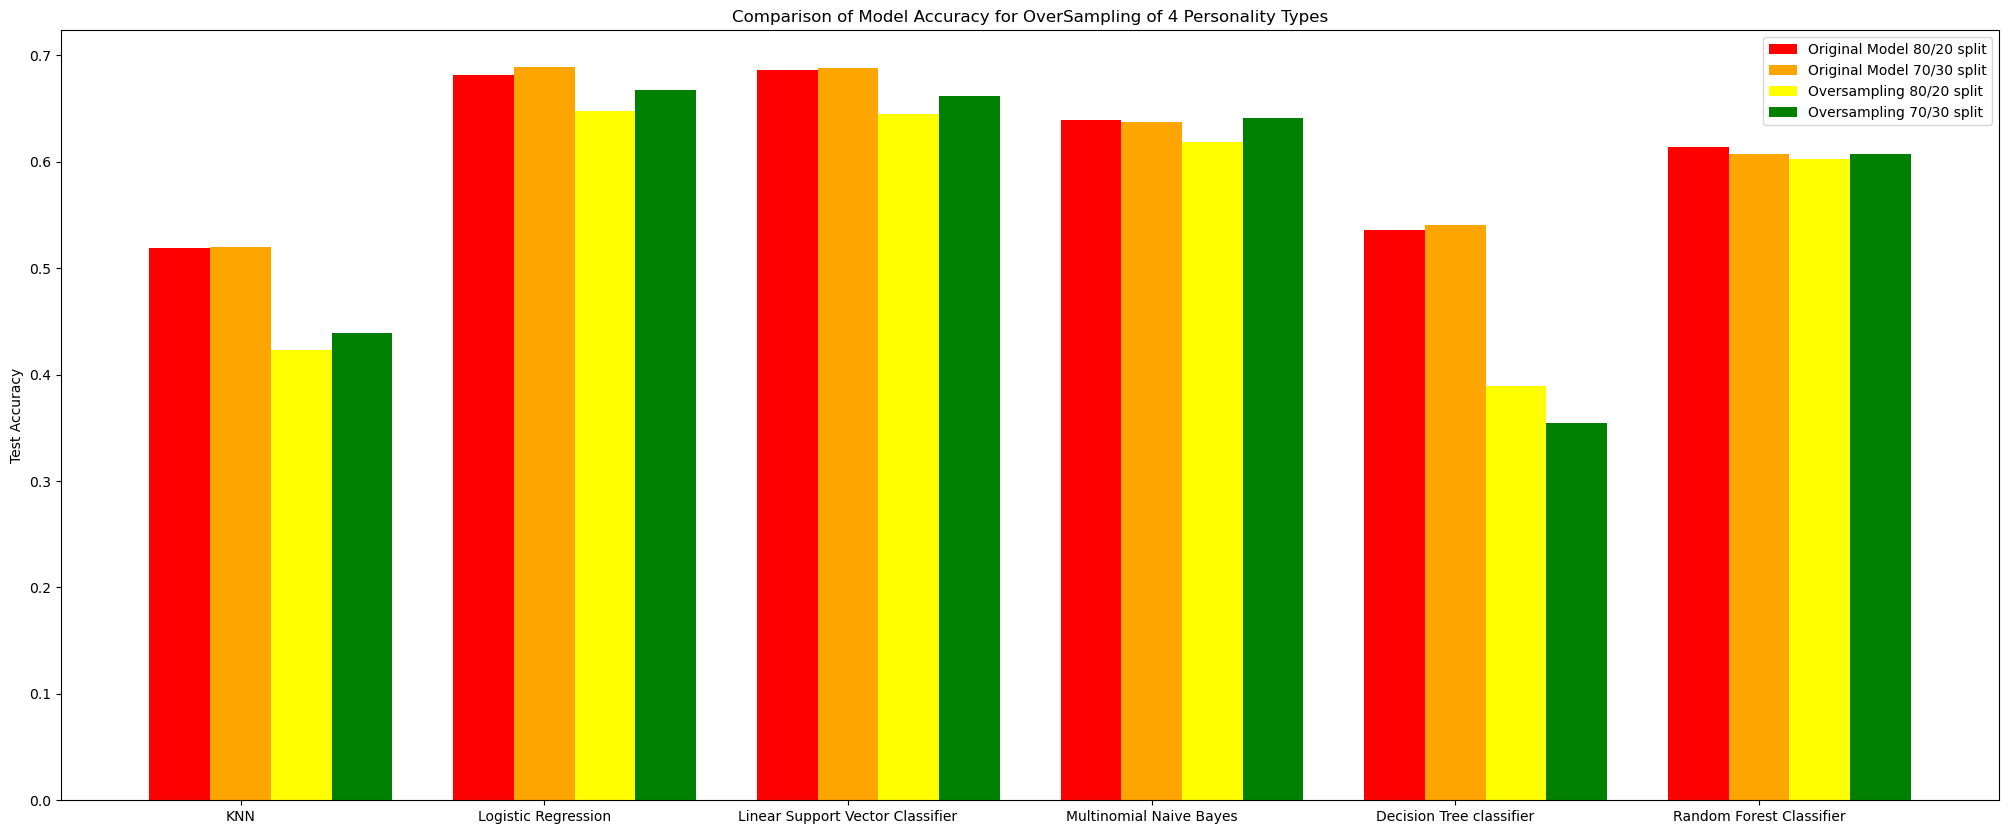

In [192]:
fig, ax = plt.subplots(figsize=(25, 10))
# Set width of each bar
bar_width = 0.2
models = model_accuracy_over_club2['Models']
# Set position of bars on X axis
r1 = np.arange(len(model_accuracy_over_club2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, model_accuracy_club2['Test accuracy'], color='red', width=bar_width, label='Original Model 80/20 split')
plt.bar(r2, model_accuracy_club3['Test accuracy'], color='orange', width=bar_width, label='Original Model 70/30 split')
plt.bar(r3, model_accuracy_over_club2['Test accuracy'], color='yellow', width=bar_width, label='Oversampling 80/20 split')
plt.bar(r4, model_accuracy_over_club3['Test accuracy'], color='green', width=bar_width, label='Oversampling 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(models))], models)

# Add y axis label and title
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Accuracy for OverSampling of 4 Personality Types')

# Add legend
plt.legend()

# Show plot
plt.show()


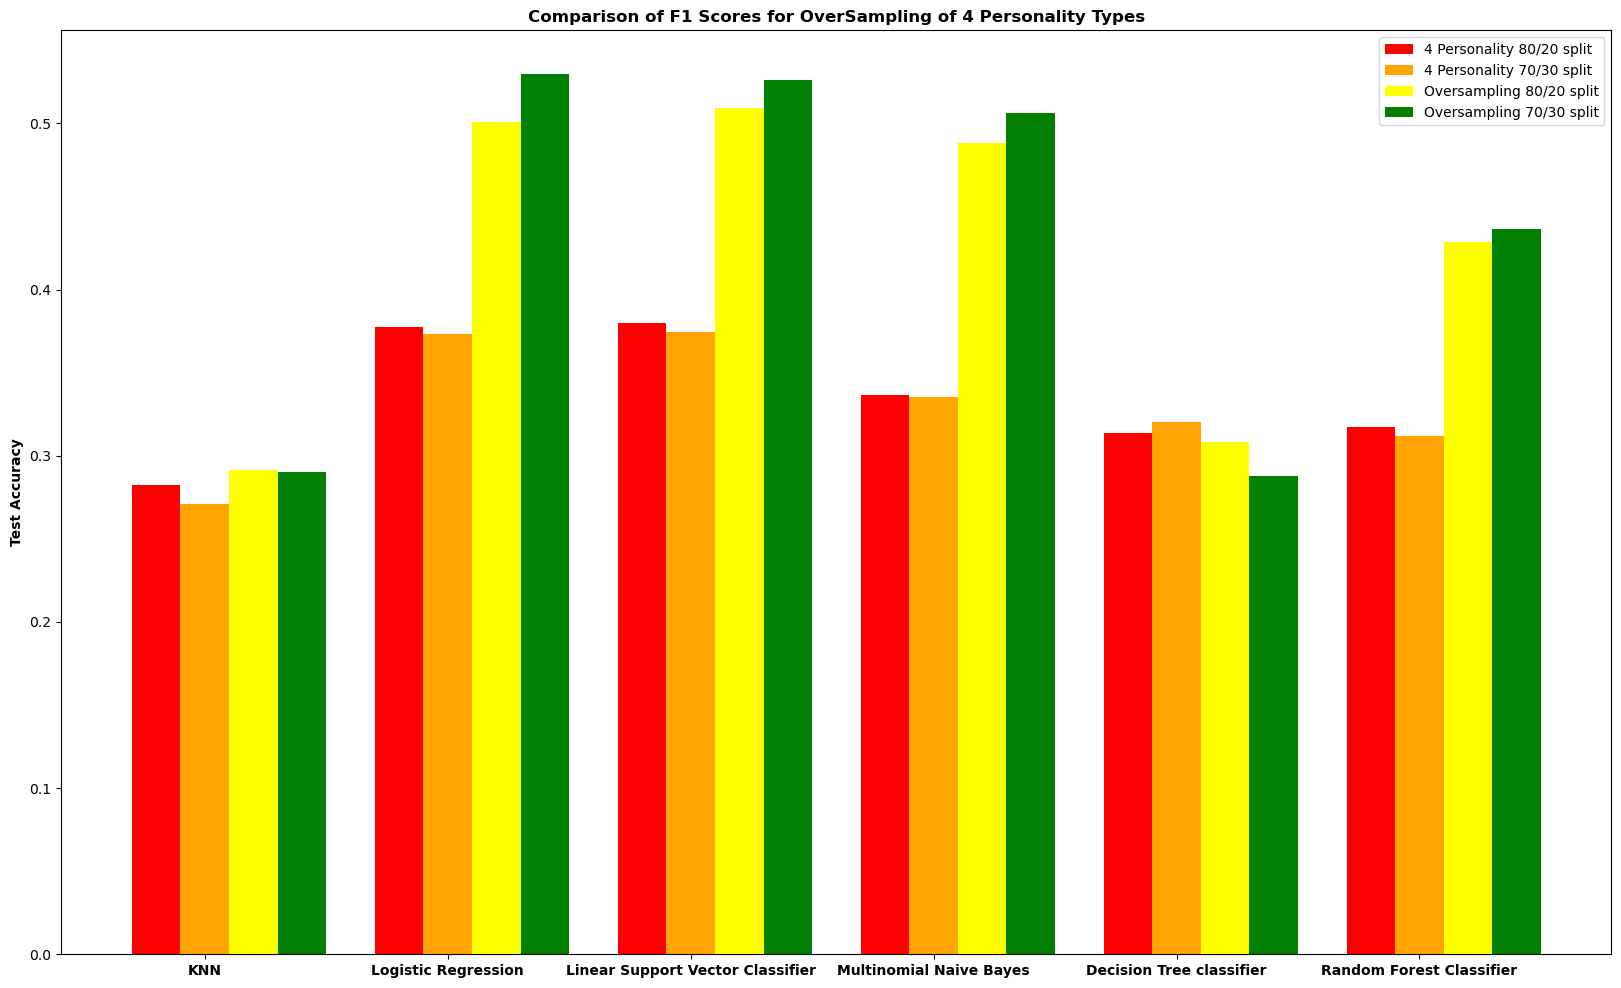

In [193]:
fig, ax = plt.subplots(figsize=(20, 12))
# Set width of each bar
bar_width = 0.2

# Set position of bars on X axis
models = f1_orig_club2['Models']
r1 = np.arange(len(f1_orig_club2['Models']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot bars
plt.bar(r1, f1_orig_club2['Test F1 Score'], color='red', width=bar_width, label='4 Personality 80/20 split')
plt.bar(r2, f1_orig_club3['Test F1 Score'], color='orange', width=bar_width, label='4 Personality 70/30 split')
plt.bar(r3, f1_over_club2['Test F1 Score'], color='yellow', width=bar_width, label='Oversampling 80/20 split')
plt.bar(r4, f1_over_club3['Test F1 Score'], color='green', width=bar_width, label='Oversampling 70/30 split')

# Add xticks and labels
plt.xticks([r + bar_width for r in range(len(models))], models,fontweight='bold')

# Add y axis label and title
plt.ylabel('Test Accuracy',fontweight='bold')
plt.title('Comparison of F1 Scores for OverSampling of 4 Personality Types',fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()


# 3. SMOTE

## For 80/20 Split

In [194]:
X_train_club2_temp = X_train_club2
y_train_club2_temp = y_train_club2
for i in range(4):
    X_train_sm_club2, y_train_sm_club2 = smote.fit_resample(X_train_club2_temp,y_train_club2_temp)
    X_train_club2_temp = X_train_sm_club2
    y_train_club2_temp = y_train_sm_club2

In [195]:
X_train_club2.shape

(6940, 5000)

In [196]:
X_train_sm_club2.shape

(13332, 5000)

In [197]:
X_train_sm_club2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06609842],
       [0.        , 0.03390049, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07976251, 0.05108795, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.08293629,
        0.        ]])

In [198]:
pd.DataFrame(y_train_sm_club2)[0].value_counts()

1    3333
0    3333
3    3333
2    3333
Name: 0, dtype: int64

In [199]:
model_accuracy_smote_club2, report_smote_club2, f1_smote_club2 = model(X_train_sm_club2, X_test_club2, y_train_sm_club2, y_test_club2, target_names_club)
model_accuracy_smote_club2.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


,Models,Test accuracy
0,Logistic Regression,0.671470
1,Linear Support Vector Classifier,0.670893
2,Multinomial Naive Bayes,0.618444
3,Random Forest Classifier,0.603458
4,Decision Tree classifier,0.489914
5,KNN,0.138329


In [200]:
f1_smote_club2.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Linear Support Vector Classifier,0.527403
1,Logistic Regression,0.521689
2,Multinomial Naive Bayes,0.479489
3,Random Forest Classifier,0.318550
4,Decision Tree classifier,0.307250
5,KNN,0.139661


## For 70/30 Split

In [201]:
X_train_club3_temp = X_train_club3
y_train_club3_temp = y_train_club3
for i in range(4):
    X_train_sm_club3, y_train_sm_club3 = smote.fit_resample(X_train_club3_temp,y_train_club3_temp)
    X_train_club3_temp = X_train_sm_club3
    y_train_club3_temp = y_train_sm_club3

In [202]:
X_train_club3.shape

(6072, 5000)

In [203]:
X_train_sm_club3.shape

(11668, 5000)

In [204]:
X_train_sm_club3

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03882334],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.02359946, 0.        , ..., 0.        , 0.        ,
        0.03394488],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [205]:
pd.DataFrame(y_train_sm_club3)[0].value_counts()

1    2917
0    2917
3    2917
2    2917
Name: 0, dtype: int64

In [206]:
model_accuracy_smote_club3, report_smote_club3, f1_smote_club3 = model(X_train_sm_club3, X_test_club3, y_train_sm_club3, y_test_club3, target_names_club)
model_accuracy_smote_club3.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

Running KNN
Running Logistic Regression
Running Linear SVC
Running Multinomial Naive Bayes
Running Decision Tree Classifier
Running Random Forest


,Models,Test accuracy
0,Linear Support Vector Classifier,0.677295
1,Logistic Regression,0.676911
2,Multinomial Naive Bayes,0.636189
3,Random Forest Classifier,0.594314
4,Decision Tree classifier,0.469074
5,KNN,0.139839


In [207]:
f1_smote_club3.sort_values(by='Test F1 Score',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test F1 Score
0,Logistic Regression,0.533731
1,Linear Support Vector Classifier,0.530384
2,Multinomial Naive Bayes,0.496052
3,Random Forest Classifier,0.314491
4,Decision Tree classifier,0.303461
5,KNN,0.139452


# Performance Visualisation of 4 Personality Models

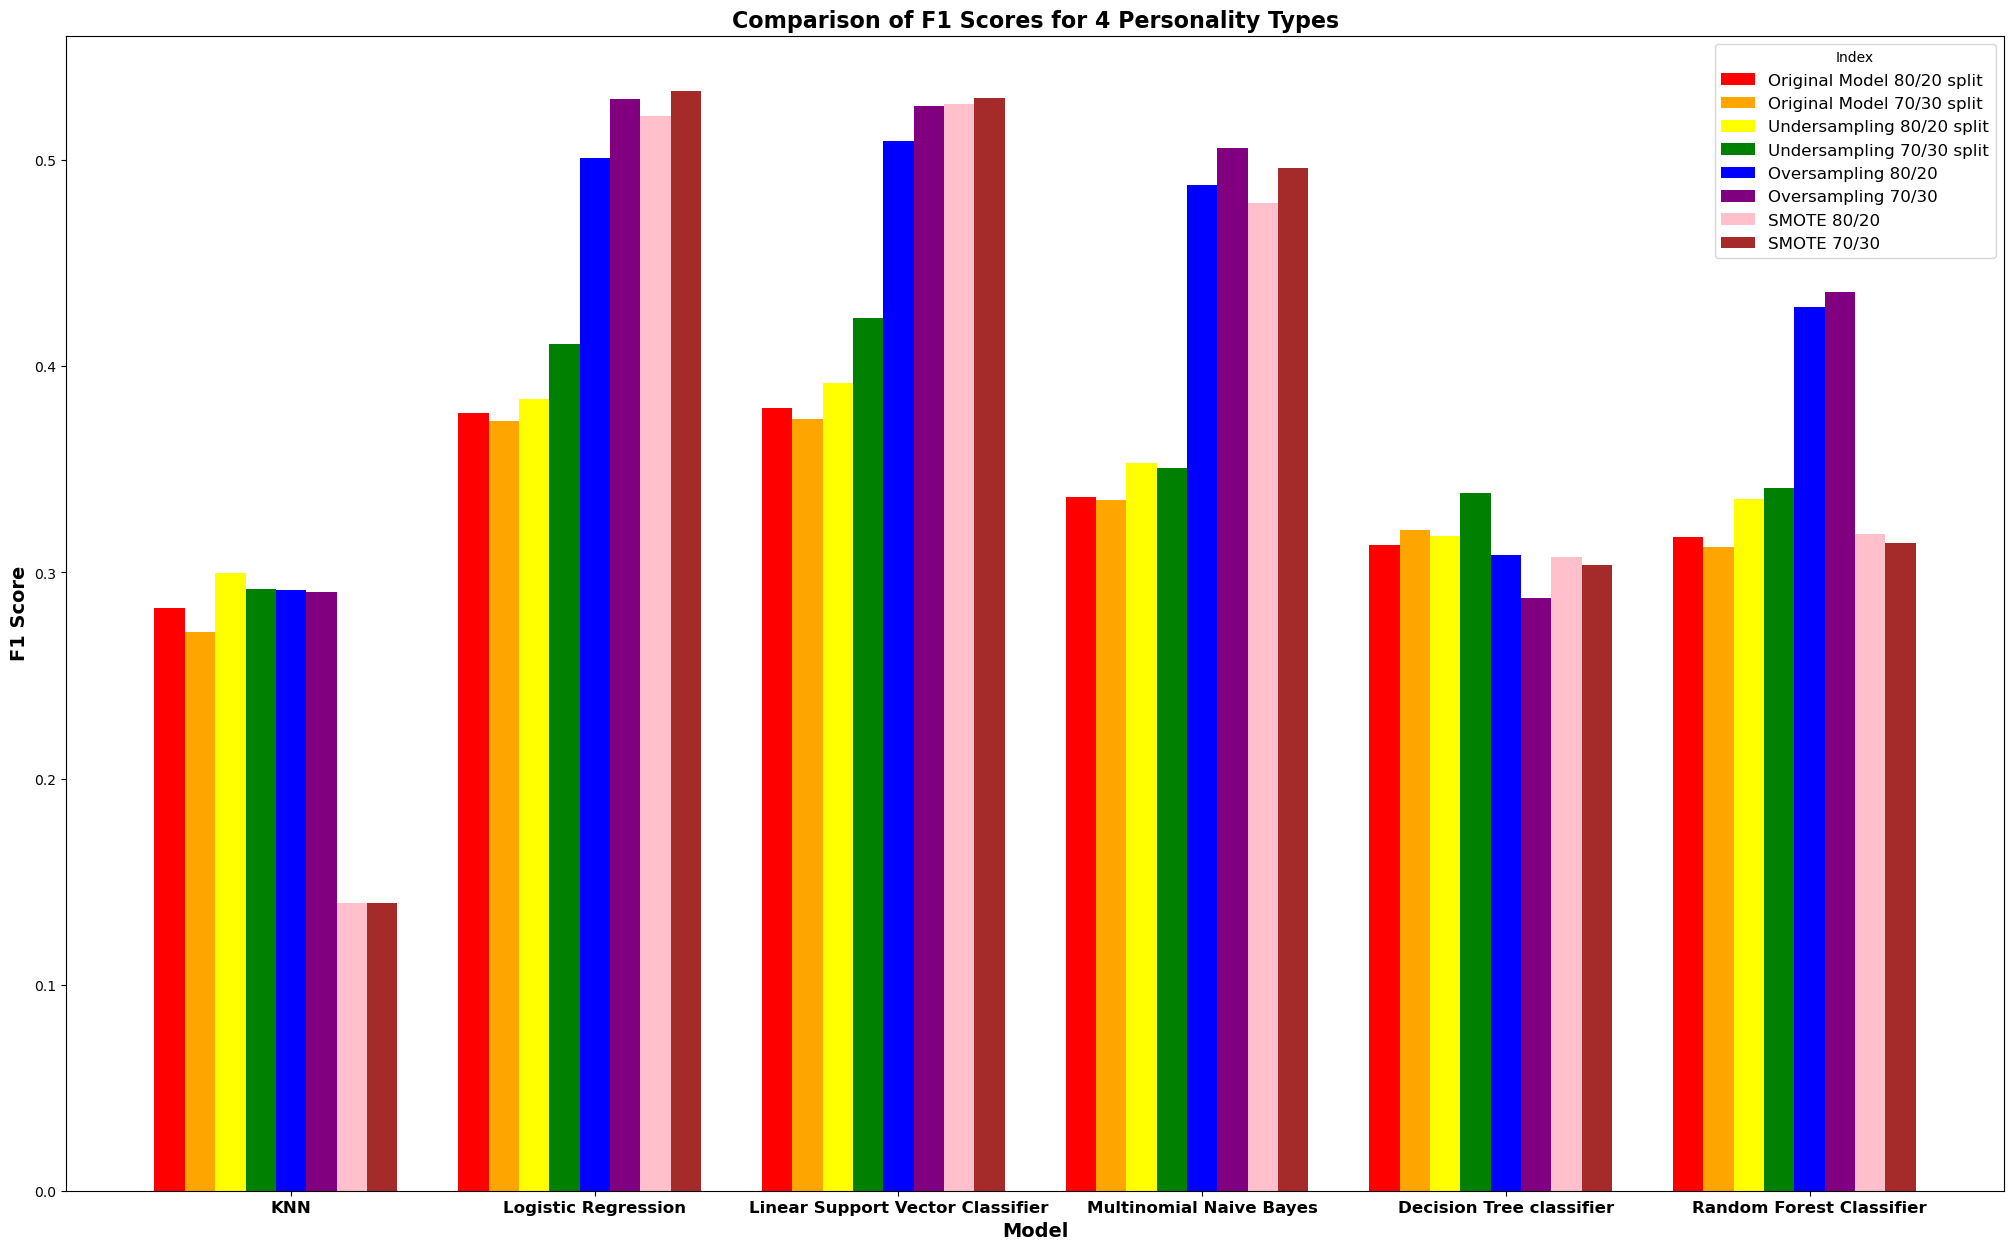

In [208]:
fig, ax = plt.subplots(figsize=(25, 15))
width = 0.1
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown']
name = ['Original Model 80/20 split', 'Original Model 70/30 split', 'Undersampling 80/20 split', 'Undersampling 70/30 split','Oversampling 80/20', 'Oversampling 70/30',
        'SMOTE 80/20', 'SMOTE 70/30']
accuracies = [f1_orig_club2, f1_orig_club3, f1_under_club2, f1_under_club3, f1_over_club2, f1_over_club3, f1_smote_club2, f1_smote_club3]
for i in range(len(accuracies)):
    ax.bar(x=np.arange(len(accuracies[i]['Models']))+i*width, height=accuracies[i]['Test F1 Score'], width=width, color=colors[i], label=f"{name[i]}")

ax.set_ylabel('F1 Score', fontweight='bold', fontsize=14)
ax.set_xlabel('Model', fontweight='bold', fontsize=14)
ax.set_title('Comparison of F1 Scores for 4 Personality Types', fontweight='bold', fontsize=16)
ax.set_xticks(np.arange(len(f1_orig_club2['Models']))+width*4)
ax.set_xticklabels(f1_orig_club2['Models'], fontweight='bold', fontsize=12)
ax.legend(title="Index", fontsize=12)
plt.show()


# END OF PROJECT
